# Hierarchical Modeling
What models fit the data?

## To-Do:

### In Progress

- show y_pred as part of the median plot
- implement model selection or feature selection
- stop accidentally generating tons of "mu" variables that are stored

### On Hold
- have median plot alpha scale with hist (requires LineCollection)
- caching (will require me to implement something)

# Setup

### Imports

In [1]:
# Stdlib imports
import os
import shutil

In [2]:
# Calculation imports
import cmdstanpy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, binned_statistic
from sklearn.metrics import root_mean_squared_error
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### Parameters

In [4]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "eval_sample_size": None,
    "nonden_fit_cols": ["references", "year"],
    "cat_col": "stan_field_code",
    "output_dir": "../../analysis_data/stan_fit",
}

In [5]:
palette = sns.color_palette()

In [6]:
def log_sum_exp(mu):
    """Calculate the log sum of exponentials
    (pulling out the max to maintain) precision.
    """
    mu_max = np.max(mu)

    summation = np.sum(np.exp(mu - mu_max))
    return mu_max + np.log(summation)

In [7]:
def log_ppd(log_p):
    M = len(log_p)
    return -np.log(M) + log_sum_exp(log_p)

### Load data

In [8]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

density  edginess  references  citations_per_year  is_center  \
0       1545.550332  0.814415          42            2.250000      False   
1       1846.261870  0.452021          88            4.625000      False   
2       1703.520959  0.490212          30            0.882353      False   
3       1901.386693  0.715160          95            8.166667      False   
4        535.472125  0.885892          94            2.090909      False   
...             ...       ...         ...                 ...        ...   
537685    48.730838  0.658585          41            3.500000      False   
537686    25.107589  0.721374          38            3.200000      False   
537687    41.647954  0.646499          11            1.529412      False   
537688    35.738649  0.708053          15            2.384615      False   
537689    31.749805  0.670620           7            0.000000      False   

                                      identifier  year librarian vectorizer  \
0       2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f  2004        S2       GPT2   
1       d7b6cd39dd111afa55a3aa418b7b5459db12988d  2012        S2       GPT2   
2       2d62ec65f95435c72ef750b3cff331382c5dca92  2003        S2       GPT2   
3       8cebc6e3dcfb543bad48d89112e281a6e11c33c2  2014        S2       GPT2   
4       59730a4bae4dc53f59341b63fd1e63451c589e9f  2009        S2       GPT2   
...                                          ...   ...       ...        ...   
537685  806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24  2018        S2    SciBERT   
537686  f40707d1165c22e185c25e6837977177ee380f2c  2015        S2    SciBERT   
537687  10636ee16779a7521001651164acb5c192d4ad7b  2003        S2    SciBERT   
537688  a229f829e0a5362d00e63781f687f40ede991635  2007        S2    SciBERT   
537689  8f7f47c0acd81752039abad380df57cf39591506  2012        S2    SciBERT   

                                center fields_of_study_0  
0       hafenLowredshiftLymanLimit2017           Physics  
1       hafenLowredshiftLymanLimit2017           Physics  
2       hafenLowredshiftLymanLimit2017           Physics  
3       hafenLowredshiftLymanLimit2017           Physics  
4       hafenLowredshiftLymanLimit2017           Physics  
...                                ...               ...  
537685                       Andre2018       Mathematics  
537686                       Andre2018       Mathematics  
537687                       Andre2018       Mathematics  
537688                       Andre2018       Mathematics  
537689                       Andre2018       Mathematics  

[537690 rows x 11 columns]

In [9]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all["log_cpy"] = df_all["log_cpy"].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# Make the field category more useful
df_all["fields_of_study_0"] = df_all["fields_of_study_0"].astype("category")
df_all["stan_field_code"] = df_all["fields_of_study_0"].cat.codes + 1
field_names = df_all["fields_of_study_0"].cat.categories
field_names

Index(['Economics', 'Education', 'Geology', 'Linguistics', 'Materials Science',
       'Mathematics', 'Medicine', 'Philosophy', 'Physics'],
      dtype='object')

In [11]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

## Prep output

In [12]:
# Clear the output dir and recreate
if os.path.exists(config["output_dir"]):
    shutil.rmtree(config["output_dir"])
os.makedirs(config["output_dir"])

# Visual Overview

### Brief aside on logscale plotting

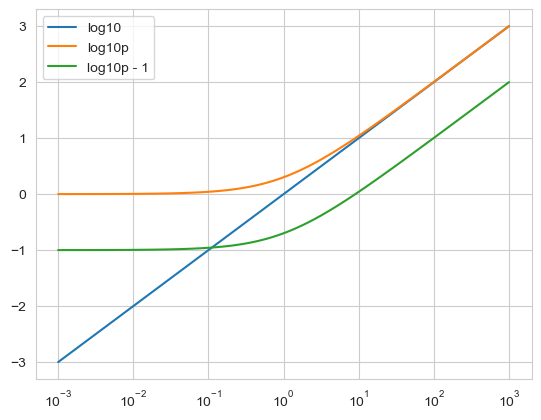

In [13]:
fig = plt.figure()
ax = plt.gca()

x = np.logspace(-3, 3, 100)
log10 = np.log10(x)
log10p = np.log10(1 + x)
log10p2 = np.log10(1 + x) - 1

ax.plot(
    x,
    log10,
    label="log10",
)
ax.plot(
    x,
    log10p,
    label="log10p",
)
ax.plot(
    x,
    log10p2,
    label="log10p - 1",
)

ax.legend()

ax.set_xscale("log")

### Overview Normalized 2D Histogram

In [14]:
def get_bins(x, n_bins=config["bins"]):
    # Get density bins
    bins = np.linspace(
        np.nanpercentile(x, config["min_bin_percentile"]),
        np.nanpercentile(x, 100 - config["min_bin_percentile"]),
        n_bins + 1,
    )
    return bins


density_bins = df_all.groupby("vectorizer")["density"].apply(get_bins).to_dict()
cpy_bins = get_bins(
    df_all["log_cpy"], n_bins=17
)  # The n_bins=17 is to ensure we don't accidentally flip axes

In [15]:
def custom_histplot(data, x, y, normed=True, *args, **kwargs):

    # Get the appropriate facets
    vectorizer = data["vectorizer"].unique()[0]
    field = data["fields_of_study_0"].unique()[0]

    density_bins = get_bins(data[x])

    if normed:
        hist2d, _, _ = np.histogram2d(data[x], data[y], bins=(density_bins, cpy_bins))
        density_hist, _ = np.histogram(data[x], bins=density_bins)
        hist2d_normed = hist2d / density_hist.reshape(1, -1).T

        # Plot the data
        plt.pcolormesh(
            density_bins,
            cpy_bins,
            hist2d_normed.T,
            shading="auto",
            cmap="viridis",
        )
    else:
        sns.histplot(data, x=x, y=y, bins=(density_bins, cpy_bins), *args, **kwargs)

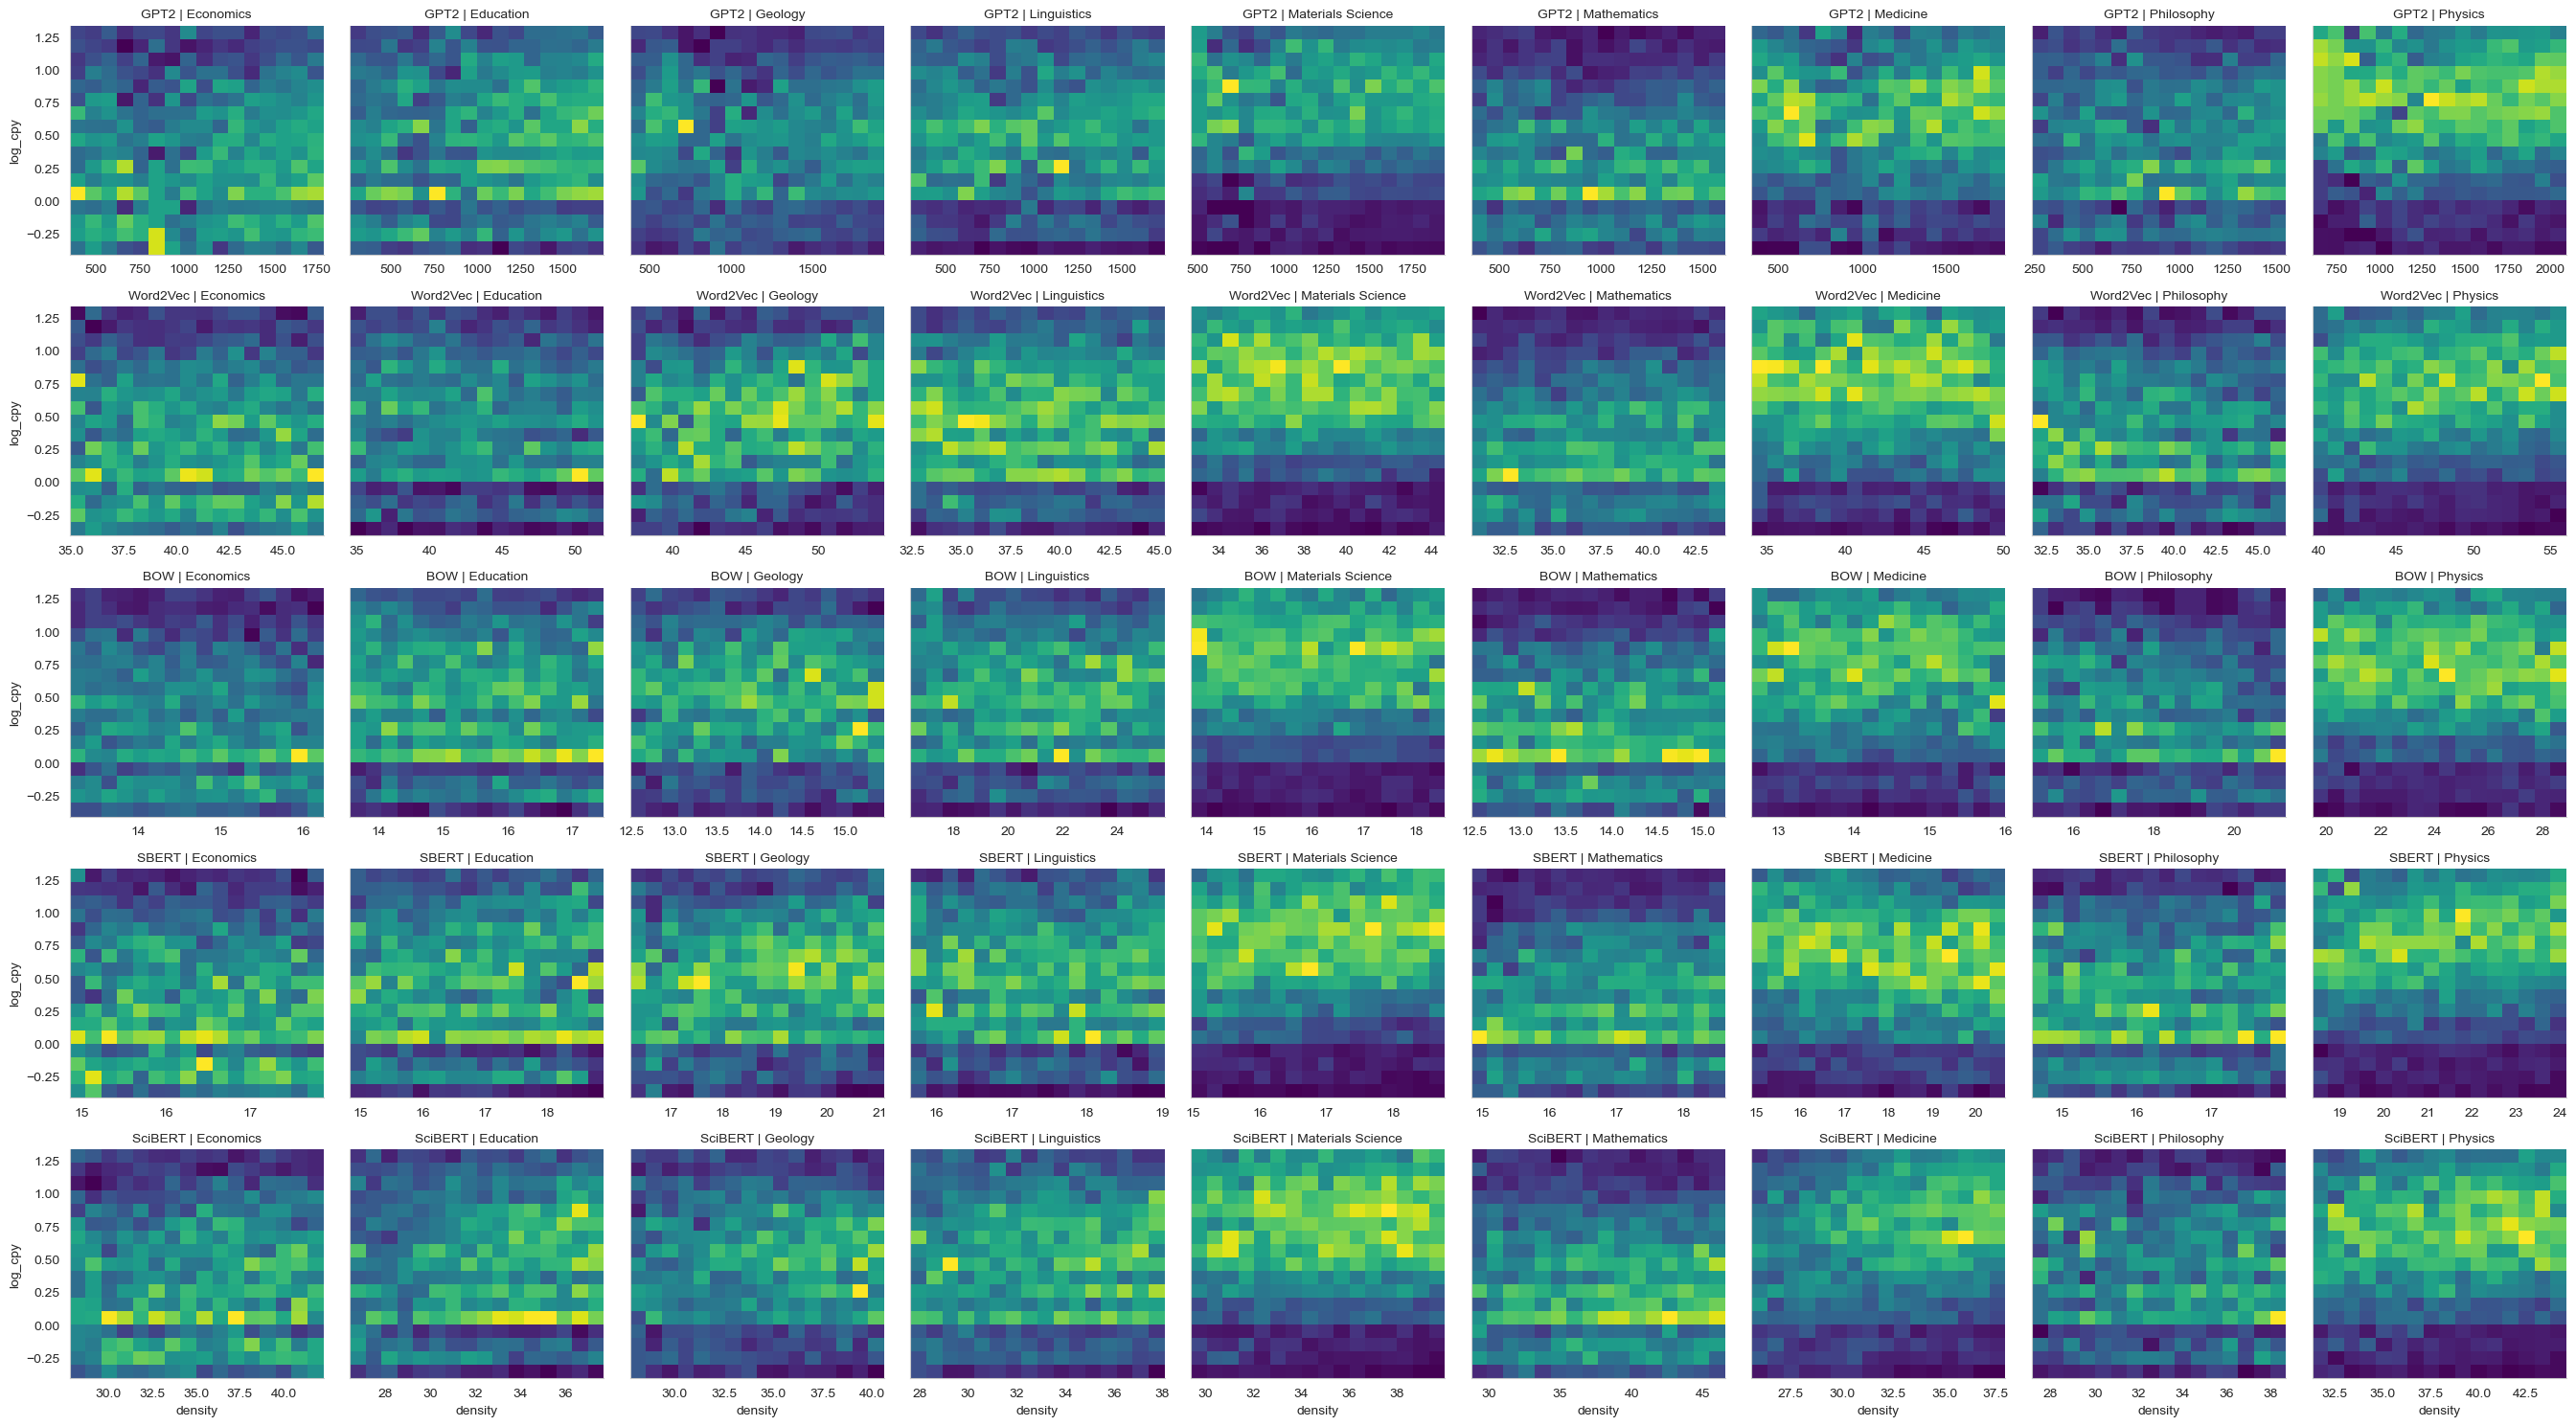

In [16]:
fg = sns.FacetGrid(data=df_all, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

### Focused Normalized Histogram

In [17]:
df = df_all.query("vectorizer in ['SciBERT', 'Word2Vec']")

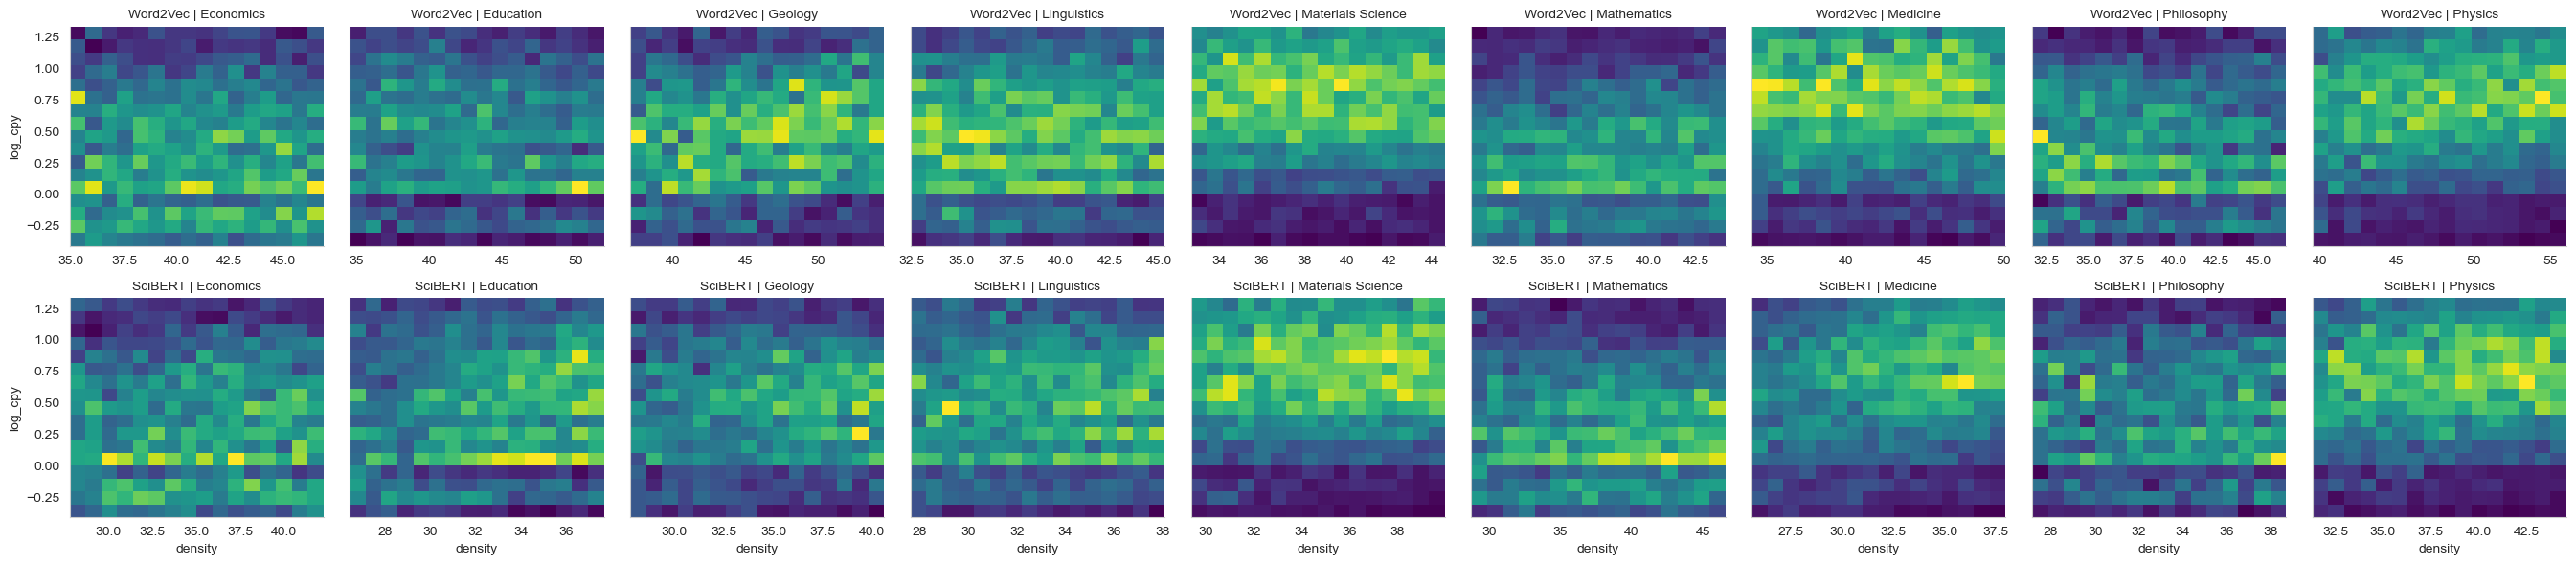

In [18]:
fg = sns.FacetGrid(data=df, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

# Statistical Modeling

Note to future self: cmdstanpy and cmdstan advertise conda as *the* way to install.
Don't listen to them.
I couldn't get it to compile when I used conda for anything cmdstanpy related.
I downloaded the repo and compiled manually, and used pip for cmdstanpy.

## Train-Test Split

In [19]:
# Pivot to wide format so we can use the same train_test division
# and so we can use multiple densities at once
df_vectorizers = df_all.pivot_table(
    index="identifier", columns="vectorizer", values="density"
)
# For the nonden cols we can take the first because the other values are duplicates
nonden_cols = [
    "log_cpy",
    config["cat_col"],
] + config["nonden_fit_cols"]
df_others = df_all.groupby("identifier")[nonden_cols].first()
df_eval = pd.concat([df_others, df_vectorizers], axis="columns")
df_eval

log_cpy  stan_field_code  \
identifier                                                            
000018fc6887cfb1fe43024b111cbfb4e21bac86  0.816610                9   
00012cd6c267ec07566e9298ad5d689462133f98 -0.176091                1   
00015dd1433923dfaecd815a5610b7e02a240bf1 -1.176091                8   
0001915f25724aabd56021ad216db4657b544bec  0.449093                2   
00019656527337df9943eb8fd5fe10035c216630  0.896251                7   
...                                            ...              ...   
fffd040a476ea5d68014a0c2d29c132bcfa5c281  0.753328                8   
fffdae38cfe952ec7fc4da420d8ad26a06384d9f -0.447158                1   
ffff5e6feb617a8cbc7867f2ef0d3422e6107697  0.946125                7   
ffffe98d67e1f39c46a8ff0d4bb745980f0f52f9       NaN                7   
fffff110e67e806c8fba3fb3fd4dcfe798569c1f -0.057992                3   

                                          references  year        BOW  \
identifier                                                              
000018fc6887cfb1fe43024b111cbfb4e21bac86         153  2011  20.247480   
00012cd6c267ec07566e9298ad5d689462133f98          81  2014  16.675367   
00015dd1433923dfaecd815a5610b7e02a240bf1           5  2005        NaN   
0001915f25724aabd56021ad216db4657b544bec          15  2004  15.214642   
00019656527337df9943eb8fd5fe10035c216630          38  2012        NaN   
...                                              ...   ...        ...   
fffd040a476ea5d68014a0c2d29c132bcfa5c281          39  2014  16.932139   
fffdae38cfe952ec7fc4da420d8ad26a06384d9f          21  2006        NaN   
ffff5e6feb617a8cbc7867f2ef0d3422e6107697          43  2002  13.273726   
ffffe98d67e1f39c46a8ff0d4bb745980f0f52f9         336  2014  13.871656   
fffff110e67e806c8fba3fb3fd4dcfe798569c1f          38  2012        NaN   

                                                 GPT2      SBERT    SciBERT  \
identifier                                                                    
000018fc6887cfb1fe43024b111cbfb4e21bac86          NaN        NaN  40.709152   
00012cd6c267ec07566e9298ad5d689462133f98  1821.844826  17.195921  44.223053   
00015dd1433923dfaecd815a5610b7e02a240bf1          NaN  15.303556        NaN   
0001915f25724aabd56021ad216db4657b544bec  1474.294829  15.101694  38.331719   
00019656527337df9943eb8fd5fe10035c216630  1824.667374  19.787877        NaN   
...                                               ...        ...        ...   
fffd040a476ea5d68014a0c2d29c132bcfa5c281  1357.686408  15.175140  34.163358   
fffdae38cfe952ec7fc4da420d8ad26a06384d9f          NaN  17.679814        NaN   
ffff5e6feb617a8cbc7867f2ef0d3422e6107697  1656.083989  15.323810  29.493443   
ffffe98d67e1f39c46a8ff0d4bb745980f0f52f9   735.093268  14.508996  30.694829   
fffff110e67e806c8fba3fb3fd4dcfe798569c1f          NaN  20.337161        NaN   

                                           Word2Vec  
identifier                                           
000018fc6887cfb1fe43024b111cbfb4e21bac86  48.709426  
00012cd6c267ec07566e9298ad5d689462133f98  46.829885  
00015dd1433923dfaecd815a5610b7e02a240bf1        NaN  
0001915f25724aabd56021ad216db4657b544bec  36.408183  
00019656527337df9943eb8fd5fe10035c216630        NaN  
...                                             ...  
fffd040a476ea5d68014a0c2d29c132bcfa5c281  42.351464  
fffdae38cfe952ec7fc4da420d8ad26a06384d9f        NaN  
ffff5e6feb617a8cbc7867f2ef0d3422e6107697  39.875730  
ffffe98d67e1f39c46a8ff0d4bb745980f0f52f9  35.870620  
fffff110e67e806c8fba3fb3fd4dcfe798569c1f        NaN  

[154295 rows x 9 columns]

In [20]:
# Drop all columns where log_cpy is na
df_eval = df_eval.dropna(subset="log_cpy")

In [21]:
# Prep to apply scaling (normalization by mean and sigma) to help with modelling
scaled_cols = (
    [
        "log_cpy",
    ]
    + config["nonden_fit_cols"]
    + vectorizer_names
)
# Convert any non-float to float so scaling doesn't throw errors
df_eval.loc[:, scaled_cols] = df_eval[scaled_cols].astype('float')
df_eval_copy = df_eval.copy() # Make a copy before modifying

In [22]:
# Global scaling
scaler = StandardScaler()
df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/3415137217.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.29427405  0.36043231 -0.62528953 ... -0.41776914 -0.13242861
 -0.19727873]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/3415137217.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.059374    0.52071293 -1.21954787 ... -1.02618556 -1.7996348
  0.13398831]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])


In [23]:
# Apply per-field scaling
scalers = {}
new_cols = [f"{col}_j" for col in scaled_cols]
for code_i, ids_i in df_eval_copy.groupby("stan_field_code").groups.items():
    df_i = df_eval_copy.loc[ids_i]

    # Scale
    scaler_i = StandardScaler()
    df_eval.loc[ids_i, new_cols] = scaler_i.fit_transform(df_i[scaled_cols])
    scalers[code_i] = scaler_i


In [24]:
# Variables for referring to scaled versions of the columns
scaled_nonden_fit_cols = [f"{col}_j" for col in config["nonden_fit_cols"]]
scaled_vectorizer_cols = [f"{vectorizer_i}_j" for vectorizer_i in vectorizer_names]
used_fit_cols = scaled_nonden_fit_cols + scaled_vectorizer_cols

In [25]:
# Downsample
if config["eval_sample_size"] is not None:
    df_eval = df_eval.sample(config["eval_sample_size"])

In [26]:
# Train-test split
df_train, df_test = train_test_split(df_eval)

In [27]:
# Save for later analysis
df_train.to_csv(f"{config["output_dir"]}/train_data.csv")
df_test.to_csv(f"{config["output_dir"]}/test_data.csv")

In [28]:
# dictionary to store results in
results_dict = {}

## Base model
The base model is just a normal distribution.

In [29]:
stan_model = "base"
model_name = "base"

In [30]:
# Dict for storing output
output = {}

In [31]:
# Drop na
df_train_i = df_train.dropna(subset=["log_cpy"])
df_test_i = df_train.dropna(subset=["log_cpy"])

In [32]:
# Format data
data = {
    "N": len(df_train_i),
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "y_test": df_test_i["log_cpy"].values,
}

In [33]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [34]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

23:54:15 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/base
23:54:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:54:22 - cmdstanpy - INFO - CmdStan done processing.
23:54:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
	Exception: normal_lpdf: Scale parameter is 0, but mus

In [35]:
# Parse output
draws = fit.draws_pd()

In [36]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()

In [37]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [38]:
results_dict[stan_model] = pd.Series(output)

## Linear on one density

In [39]:
stan_model = "reg"

### Fit

In [40]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    model_name = f"{vectorizer_i}"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])
    df_test_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])

    # Format data
    data = {
        "N": len(df_train_i),
        "x": df_train_i[vectorizer_i].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[vectorizer_i].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output[f"beta[{vectorizer_i}]"] = draws["beta"].median()
    output["sigma"] = draws["sigma"].median()

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

23:54:23 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/BOW
23:54:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:55:35 - cmdstanpy - INFO - CmdStan done processing.
23:55:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above outpu

23:55:36 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/GPT2
23:55:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:56:41 - cmdstanpy - INFO - CmdStan done processing.
23:56:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be pos

23:56:41 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/SBERT
23:56:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:57:49 - cmdstanpy - INFO - CmdStan done processing.
23:57:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above outpu

23:57:50 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/SciBERT
23:57:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:58:59 - cmdstanpy - INFO - CmdStan done processing.
23:58:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


23:59:00 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/Word2Vec
23:59:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:00:09 - cmdstanpy - INFO - CmdStan done processing.
00:00:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above outpu

### Evaluate

In [41]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = vectorizer_names

In [42]:
def medianplot(data, x, y, bins, ax, alpha_min=0.1, alpha_max=1.0):

    x = data[x]
    y = data[y]

    centers = (bins[1:] + bins[:-1]) / 2

    # TODO: Use or remove. Needs a LineCollection to work
    # # Calculate histogram (used for line transparency)
    # hist, _ = np.histogram(x, bins=bins, density=True)
    # hist /= hist.max()
    # alpha = alpha_min + hist * (alpha_max - alpha_min)

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, y, statistic=np.nanmedian, bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
        # alpha=alpha,
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.2,
    )

    ax.set_xlim(bins[0], bins[-1])

In [43]:
left_edge = np.nanpercentile(
    df_eval[vectorizer_names].values.flatten(), config["min_bin_percentile"]
)
right_edge = -left_edge
bins = np.linspace(left_edge, right_edge, config["bins"])

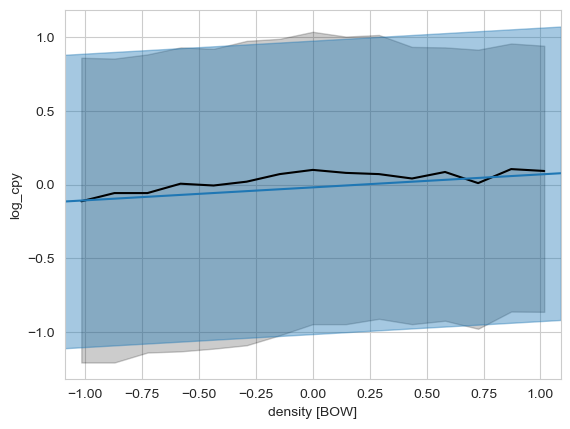

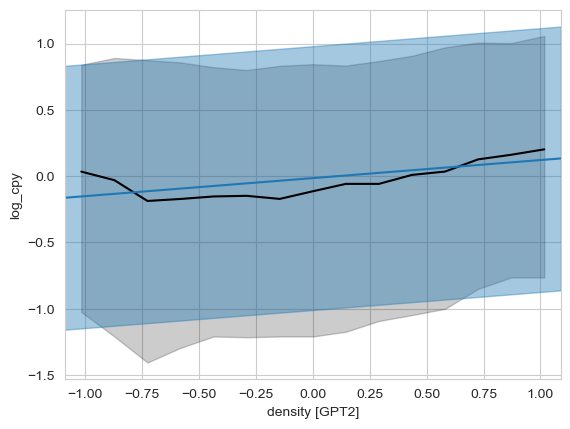

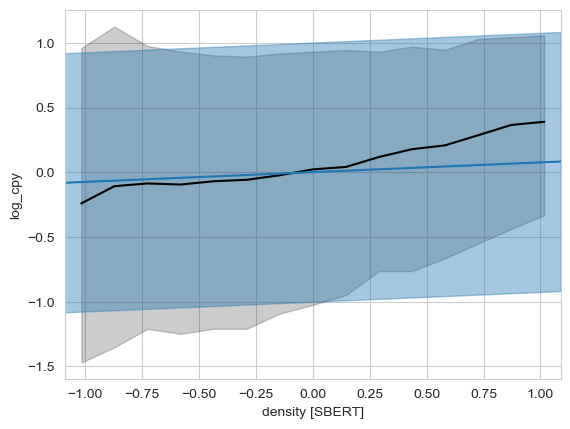

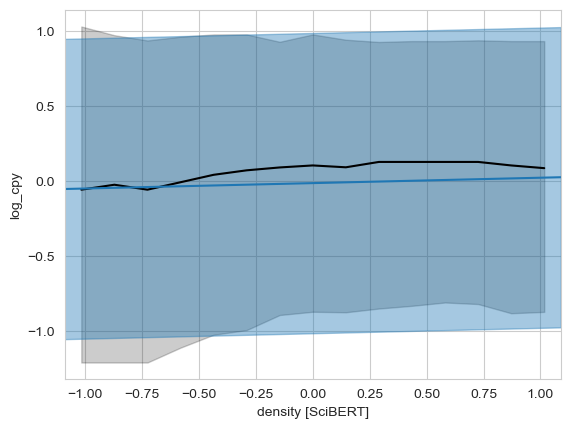

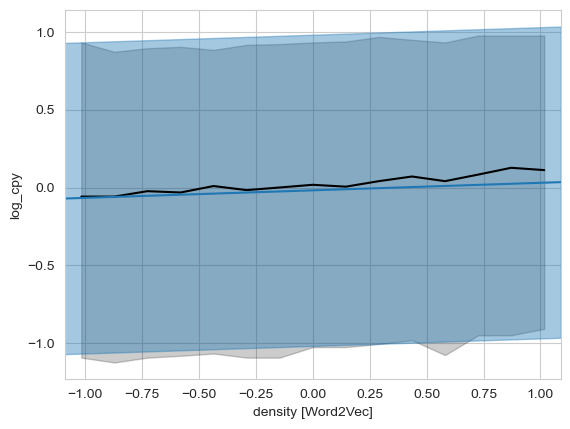

In [44]:
for i, row in output.iterrows():
    fig = plt.figure()
    ax = plt.gca()

    df_plot = df_eval.dropna(subset=[row["vectorizer"], "log_cpy"])

    medianplot(
        data=df_plot,
        x=row["vectorizer"],
        y="log_cpy",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{row["vectorizer"]}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.4,
    )

    ax.set_xlabel(f"density [{row["vectorizer"]}]")
    ax.set_ylabel("log_cpy")

    

## Linear on non-density vars
The next model is a multivate linear regression with no density

In [45]:
stan_model = "multireg"
model_name = "nondens"

In [46]:
fit_cols = config["nonden_fit_cols"]
cols = [
    "log_cpy",
] + fit_cols

In [47]:
# Dict for storing output
output = {}

In [48]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [49]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [50]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [51]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

00:00:12 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/nondens
00:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:02:11 - cmdstanpy - INFO - CmdStan done processing.
00:02:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


In [52]:
# Parse output
draws = fit.draws_pd()

In [53]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [54]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [55]:
results_dict[model_name] = pd.Series(output)

## Linear on one density + non-density vars

In [56]:
stan_model = "multireg"

In [57]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    model_name = f"{vectorizer_i} + nondens"

    # Drop na
    fit_cols = [
        vectorizer_i,
    ] + config["nonden_fit_cols"]
    cols = [
        "log_cpy",
    ] + fit_cols
    df_train_i = df_train.dropna(subset=cols)
    df_test_i = df_train.dropna(subset=cols)

    # Format data
    data = {
        "N": len(df_train_i),
        "K": len(fit_cols),
        "x": df_train_i[fit_cols].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output["sigma"] = draws["sigma"].median()
    beta_cols = [col for col in draws.columns if col[:4] == "beta"]
    betas = draws[beta_cols].median(axis="rows")
    for i, fit_col in enumerate(fit_cols):
        output[f"beta[{fit_col}]"] = betas.iloc[i]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

00:02:12 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/BOW + nondens
00:02:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:03:38 - cmdstanpy - INFO - CmdStan done processing.
00:03:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


00:03:39 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/GPT2 + nondens
00:03:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:05:08 - cmdstanpy - INFO - CmdStan done processing.


00:05:10 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/SBERT + nondens
00:05:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:37:58 - cmdstanpy - INFO - CmdStan done processing.
00:37:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with s

00:38:03 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/SciBERT + nondens
00:38:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:02:41 - cmdstanpy - INFO - CmdStan done processing.
01:02:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


01:02:46 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/Word2Vec + nondens
01:02:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:05:12 - cmdstanpy - INFO - CmdStan done processing.
01:05:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


## Linear on all densities + non-density vars
The next model is a multivate linear regression using every variable we have

In [58]:
stan_model = "multireg"
model_name = "dens + nondens"

In [59]:
fit_cols = config["nonden_fit_cols"] + vectorizer_names
cols = [
    "log_cpy",
] + fit_cols

In [60]:
# Dict for storing output
output = {}

In [61]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [62]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [63]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [64]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

01:05:17 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/dens + nondens
01:05:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:06:55 - cmdstanpy - INFO - CmdStan done processing.
01:06:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


In [65]:
# Parse output
draws = fit.draws_pd()

In [66]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [67]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [68]:
results_dict[model_name] = pd.Series(output)

## Hierarchical linear on one density

In [69]:
stan_model = "hreg"

In [70]:
# Switch to per-field scalings
y_col = "log_cpy_j"

### Fit

In [71]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(scaled_vectorizer_cols):
    output = {
        "y_col": y_col,
    }

    model_name = f"h-{vectorizer_i}"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, y_col])
    df_test_i = df_train.dropna(subset=[vectorizer_i, y_col])

    # Format data
    data = {
        "D": 1,
        "N": len(df_train_i),
        "L": df_train_i[config["cat_col"]].max(),
        "y": df_train_i[y_col].values,
        "ll": df_train_i[config["cat_col"]].values,
        "x": df_train_i[[vectorizer_i]].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[[vectorizer_i]].values,
        "y_test": df_test_i[y_col].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    stan_vars = fit.stan_variables()

    # Store parameters
    output["alpha"] = np.median(stan_vars["alpha"])
    output["sigma"] = np.median(stan_vars["sigma"])

    # Store per-field betas
    betas = np.nanmedian(stan_vars["beta"], axis=0)
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{vectorizer_i},{field_name_j}]"] = betas[j][0]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

01:07:00 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-BOW_j
01:07:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:34:03 - cmdstanpy - INFO - CmdStan done processing.
01:34:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but m

01:55:04 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-GPT2_j
01:55:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:04:42 - cmdstanpy - INFO - CmdStan done processing.
02:04:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


02:08:00 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-SBERT_j
02:08:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:57 - cmdstanpy - INFO - CmdStan done processing.
02:33:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the ab

02:55:27 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-SciBERT_j
02:55:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:37 - cmdstanpy - INFO - CmdStan done processing.
03:37:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must 

04:00:14 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-Word2Vec_j
04:00:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:46:33 - cmdstanpy - INFO - CmdStan done processing.
04:46:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must

### Evaluate

In [72]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = scaled_vectorizer_cols

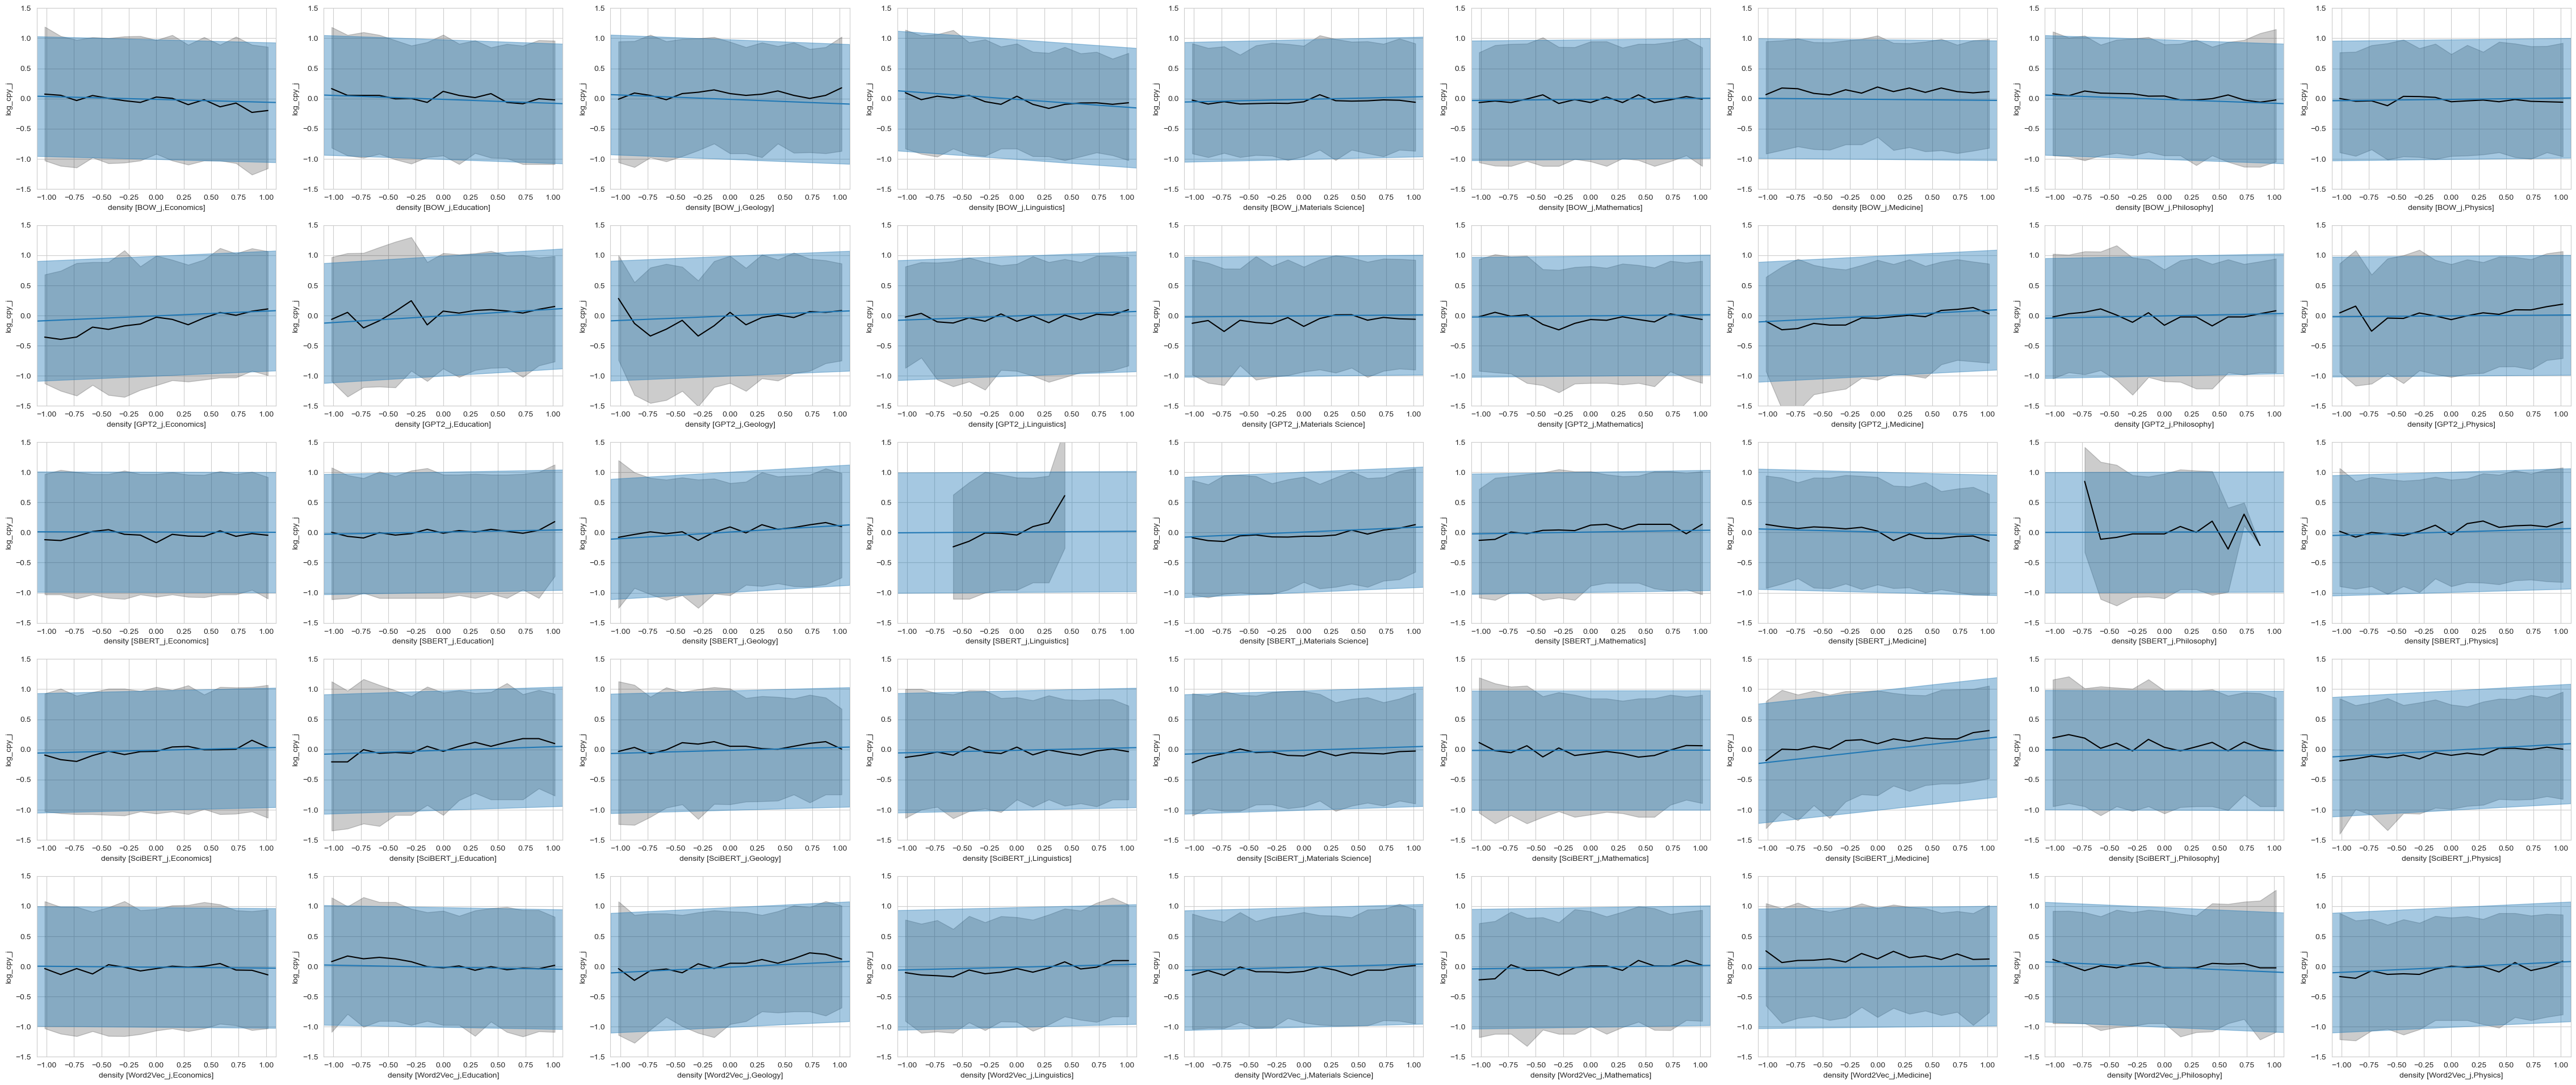

In [73]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(scaled_vectorizer_cols)))
mosaic = [[f"{vectorizer_i}_{field_j}" for field_j in field_names] for vectorizer_i in scaled_vectorizer_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, (model_i, row) in enumerate(output.iterrows()):
    vectorizer_i = row["vectorizer"]
    for j, field_j in enumerate(field_names):

        ax_key = f"{vectorizer_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=row["vectorizer"],
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = row["alpha"] + row[f"beta[{row["vectorizer"]},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - row["sigma"],
            ys + row["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{row["vectorizer"]},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)

        

## Hierarchical on non-density vars

In [ ]:
stan_model = "hreg"

In [ ]:
y_col = "log_cpy_j"

### Fit

In [ ]:
output = {
    "y_col": y_col,
}

model_name = f"h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(scaled_nonden_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[scaled_nonden_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[scaled_nonden_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
for k, fit_col_k in enumerate(scaled_nonden_fit_cols):
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

13:23:31 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-nondens
13:23:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:32 - cmdstanpy - INFO - CmdStan done processing.
14:02:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


## Hierarchical linear on one density + nondenvars

In [74]:
stan_model = "hreg"

In [75]:
# Switch to per-field scalings
y_col = "log_cpy_j"

### Fit

In [76]:
# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(scaled_vectorizer_cols):
    output = {
        "y_col": y_col,
    }

    model_name = f"h-{vectorizer_i} + h-nondens"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, y_col])
    df_test_i = df_train.dropna(subset=[vectorizer_i, y_col])

    fit_cols_i = scaled_nonden_fit_cols + [vectorizer_i, ]

    # Format data
    data = {
        "D": len(fit_cols_i),
        "N": len(df_train_i),
        "L": df_train_i[config["cat_col"]].max(),
        "y": df_train_i[y_col].values,
        "ll": df_train_i[config["cat_col"]].values,
        "x": df_train_i[fit_cols_i].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols_i].values,
        "y_test": df_test_i[y_col].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    stan_vars = fit.stan_variables()

    # Store parameters
    output["alpha"] = np.median(stan_vars["alpha"])
    output["sigma"] = np.median(stan_vars["sigma"])

    # Store per-field and per var betas
    betas = np.nanmedian(stan_vars["beta"], axis=0)
    for k, fit_col_k in enumerate(fit_cols_i):
        for j, field_name_j in enumerate(field_names):
            output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

05:25:31 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-BOW_j + h-nondens
05:25:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:23:49 - cmdstanpy - INFO - CmdStan done processing.
06:23:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


06:59:15 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-GPT2_j + h-nondens
06:59:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:18:16 - cmdstanpy - INFO - CmdStan done processing.
08:18:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but m

08:55:47 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-SBERT_j + h-nondens
08:55:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:40:18 - cmdstanpy - INFO - CmdStan done processing.
09:40:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must

10:52:53 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-SciBERT_j + h-nondens
10:52:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:24:15 - cmdstanpy - INFO - CmdStan done processing.
11:24:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the abov

11:48:17 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-Word2Vec_j + h-nondens
11:48:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:43:24 - cmdstanpy - INFO - CmdStan done processing.
12:43:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[2] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Exception: normal_lpdf: Scale parameter[2] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but

### Evaluate

In [77]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = scaled_vectorizer_cols

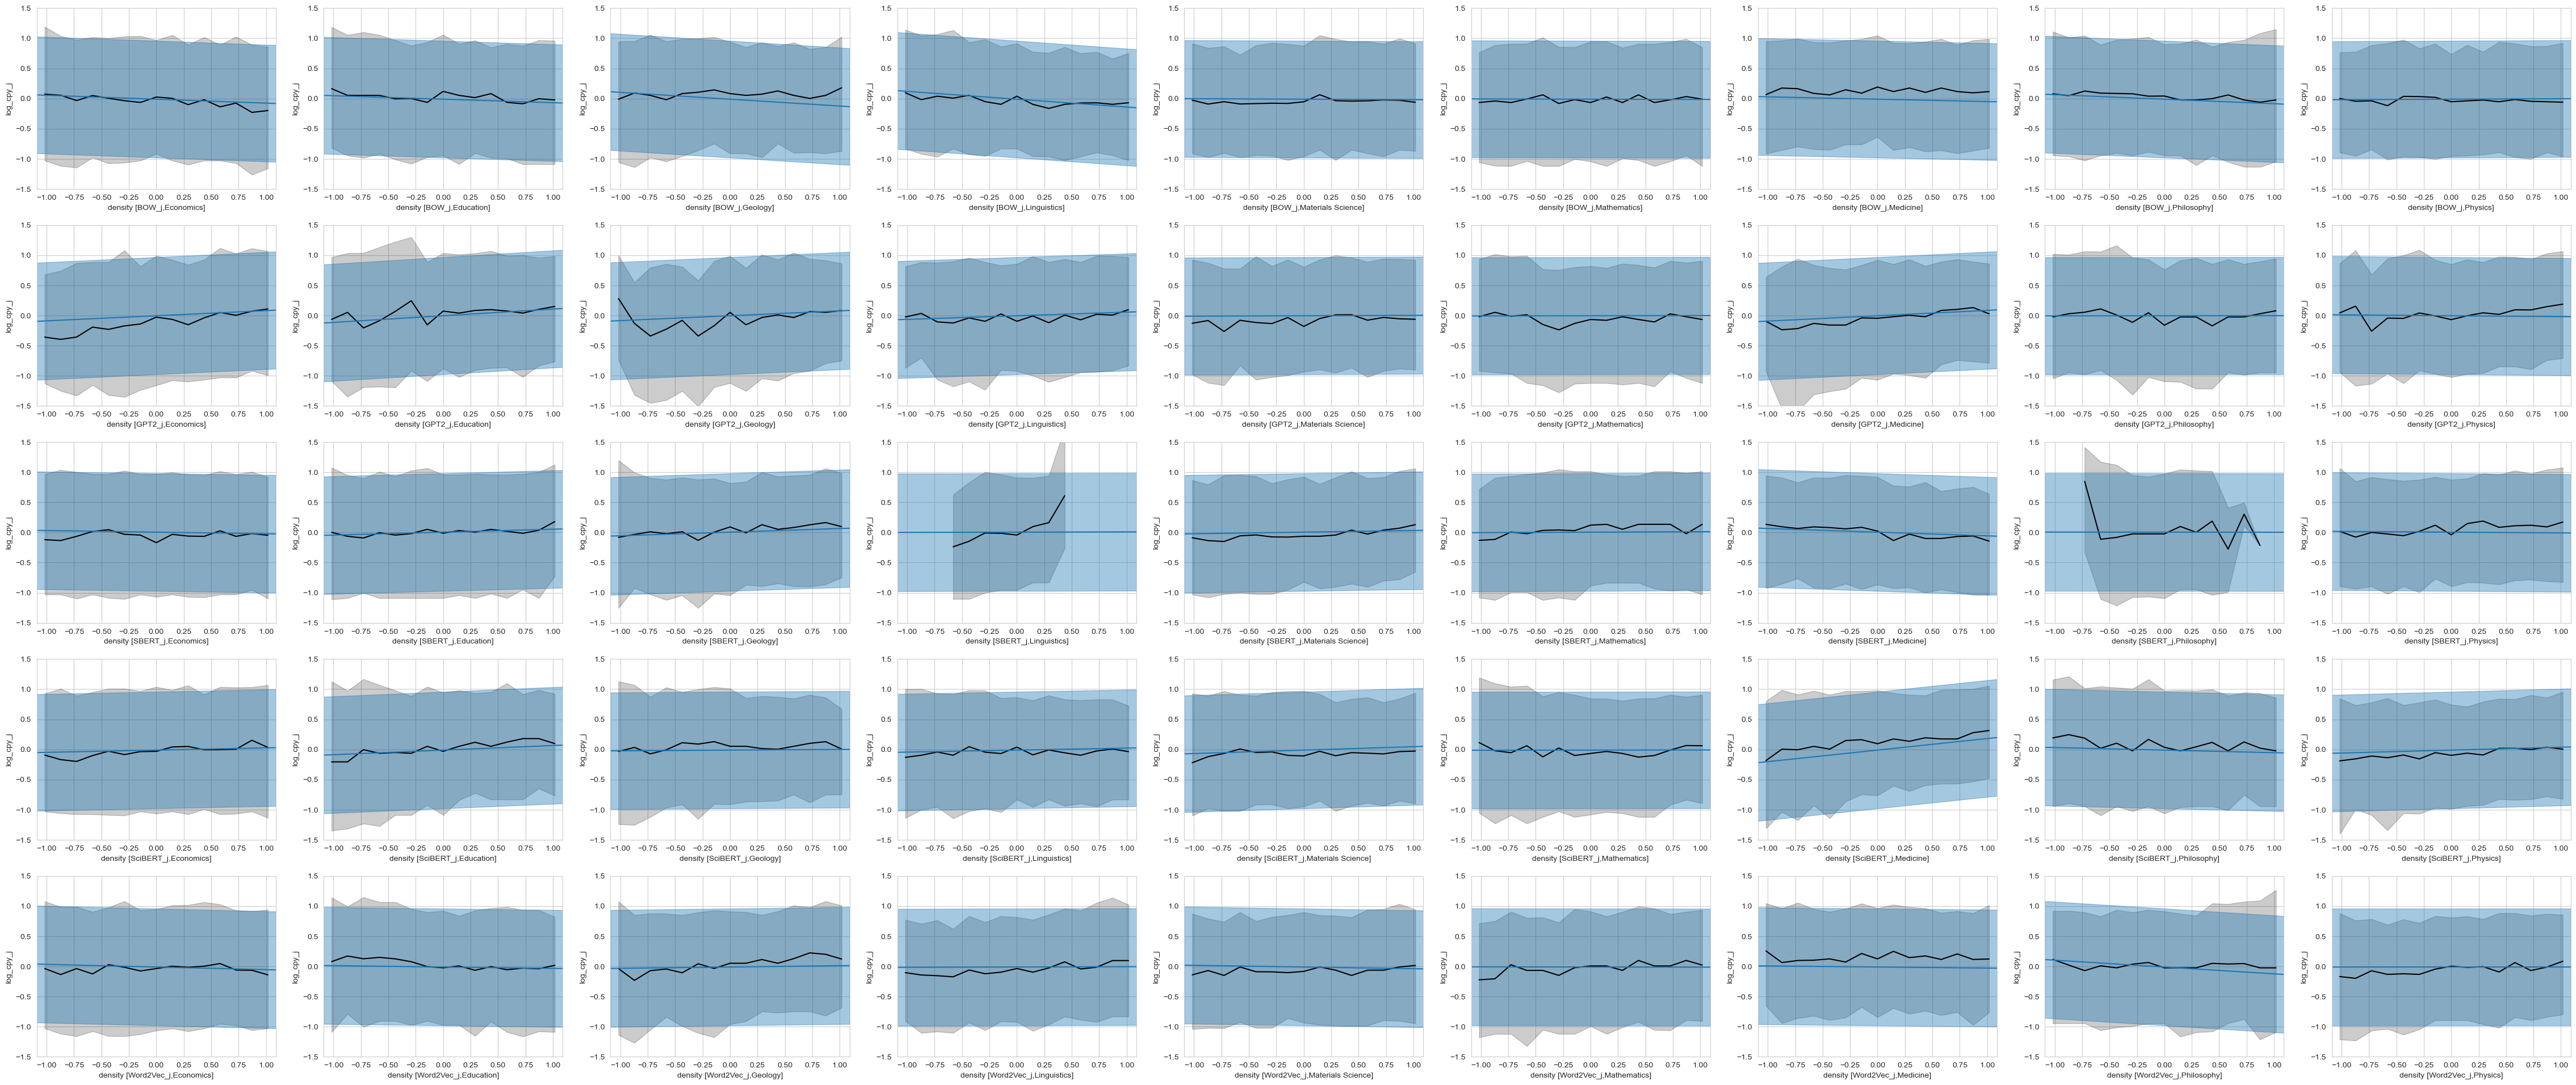

In [78]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(scaled_vectorizer_cols)))
mosaic = [[f"{vectorizer_i}_{field_j}" for field_j in field_names] for vectorizer_i in scaled_vectorizer_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, (model_i, row) in enumerate(output.iterrows()):
    vectorizer_i = row["vectorizer"]
    for j, field_j in enumerate(field_names):

        ax_key = f"{vectorizer_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=row["vectorizer"],
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = row["alpha"] + row[f"beta[{row["vectorizer"]},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - row["sigma"],
            ys + row["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{row["vectorizer"]},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)

        

## Hierarchical on two densities + non-density vars

In [ ]:
stan_model = "hreg"

In [ ]:
y_col = "log_cpy_j"

In [108]:
used_fit_cols = [_ for _ in used_fit_cols if _ in ["BOW_j", "SciBERT_j",] + scaled_nonden_fit_cols]
used_fit_cols

['references_j', 'year_j', 'BOW_j', 'SciBERT_j']

### Fit

In [ ]:
output = {
    "y_col": y_col,
}

model_name = f"h-BOW-SciBERT + h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(used_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[used_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[used_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
for k, fit_col_k in enumerate(scaled_fit_cols):
    if fit_col_k not in used_fit_cols:
        continue
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

14:07:48 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-dens + h-nondens
14:07:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:50:17 - cmdstanpy - INFO - CmdStan done processing.
15:50:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[5] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


### Evaluate

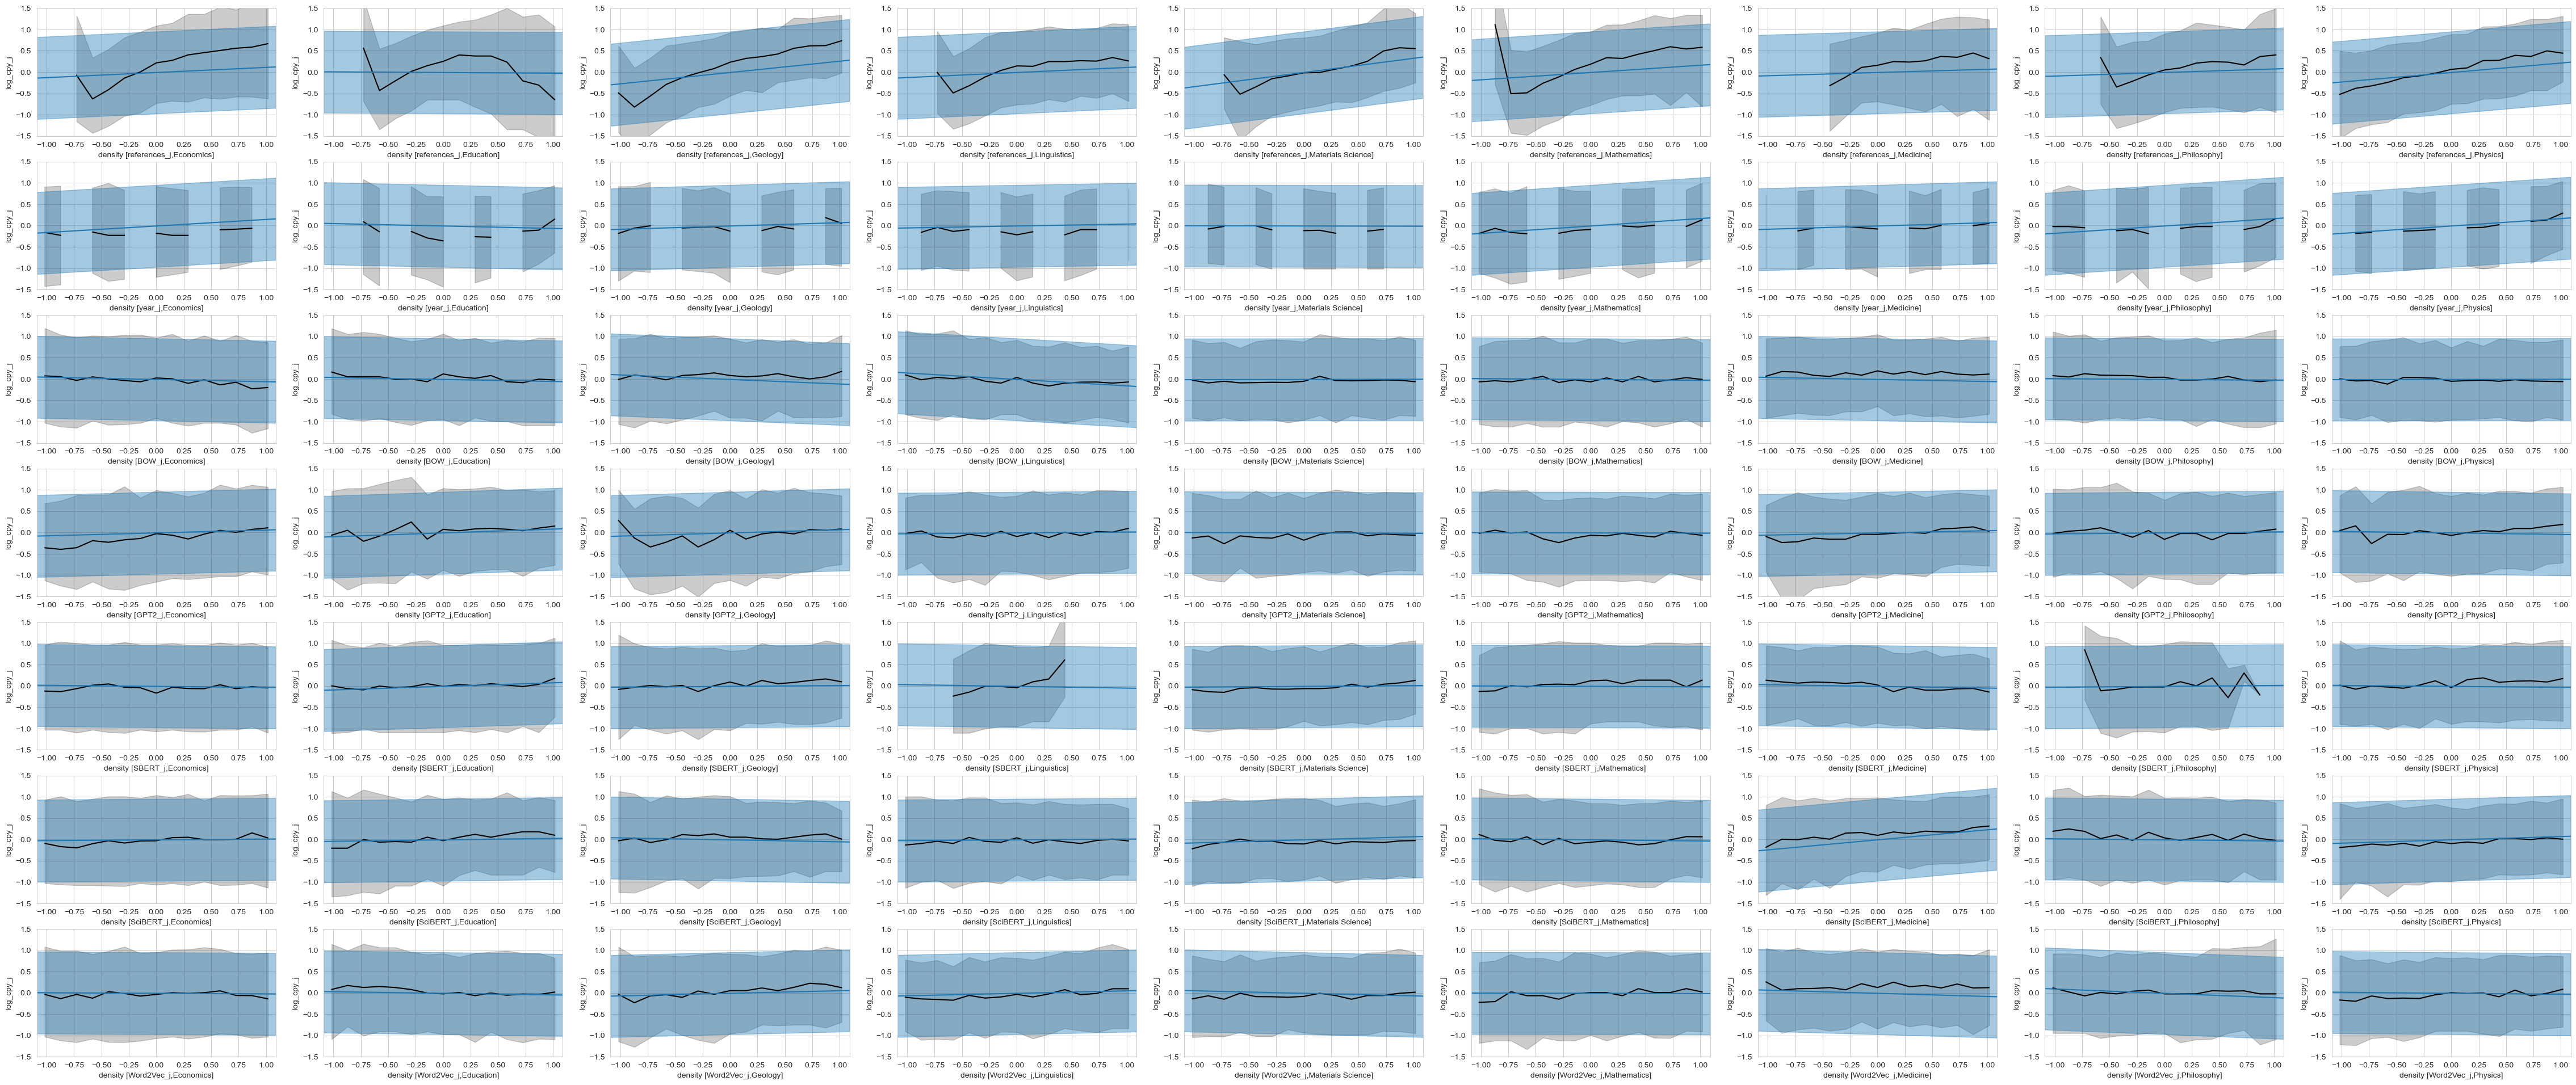

In [ ]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(vectorizer_names)))
mosaic = [[f"{fit_col_i}_{field_j}" for field_j in field_names] for fit_col_i in used_fit_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, fit_col_i in enumerate(used_fit_cols):
    for j, field_j in enumerate(field_names):

        ax_key = f"{fit_col_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=fit_col_i,
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = output["alpha"] + output[f"beta[{fit_col_i},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - output["sigma"],
            ys + output["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{fit_col_i},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)
        

## Hierarchical on all densities + non-density vars

In [82]:
stan_model = "hreg"

In [83]:
y_col = "log_cpy_j"

### Fit

In [84]:
output = {
    "y_col": y_col,
}

model_name = f"h-dens + h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(used_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[used_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[used_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
for k, fit_col_k in enumerate(used_fit_cols):
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

14:07:48 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fit/h-dens + h-nondens
14:07:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:50:17 - cmdstanpy - INFO - CmdStan done processing.
15:50:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[5] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


### Evaluate

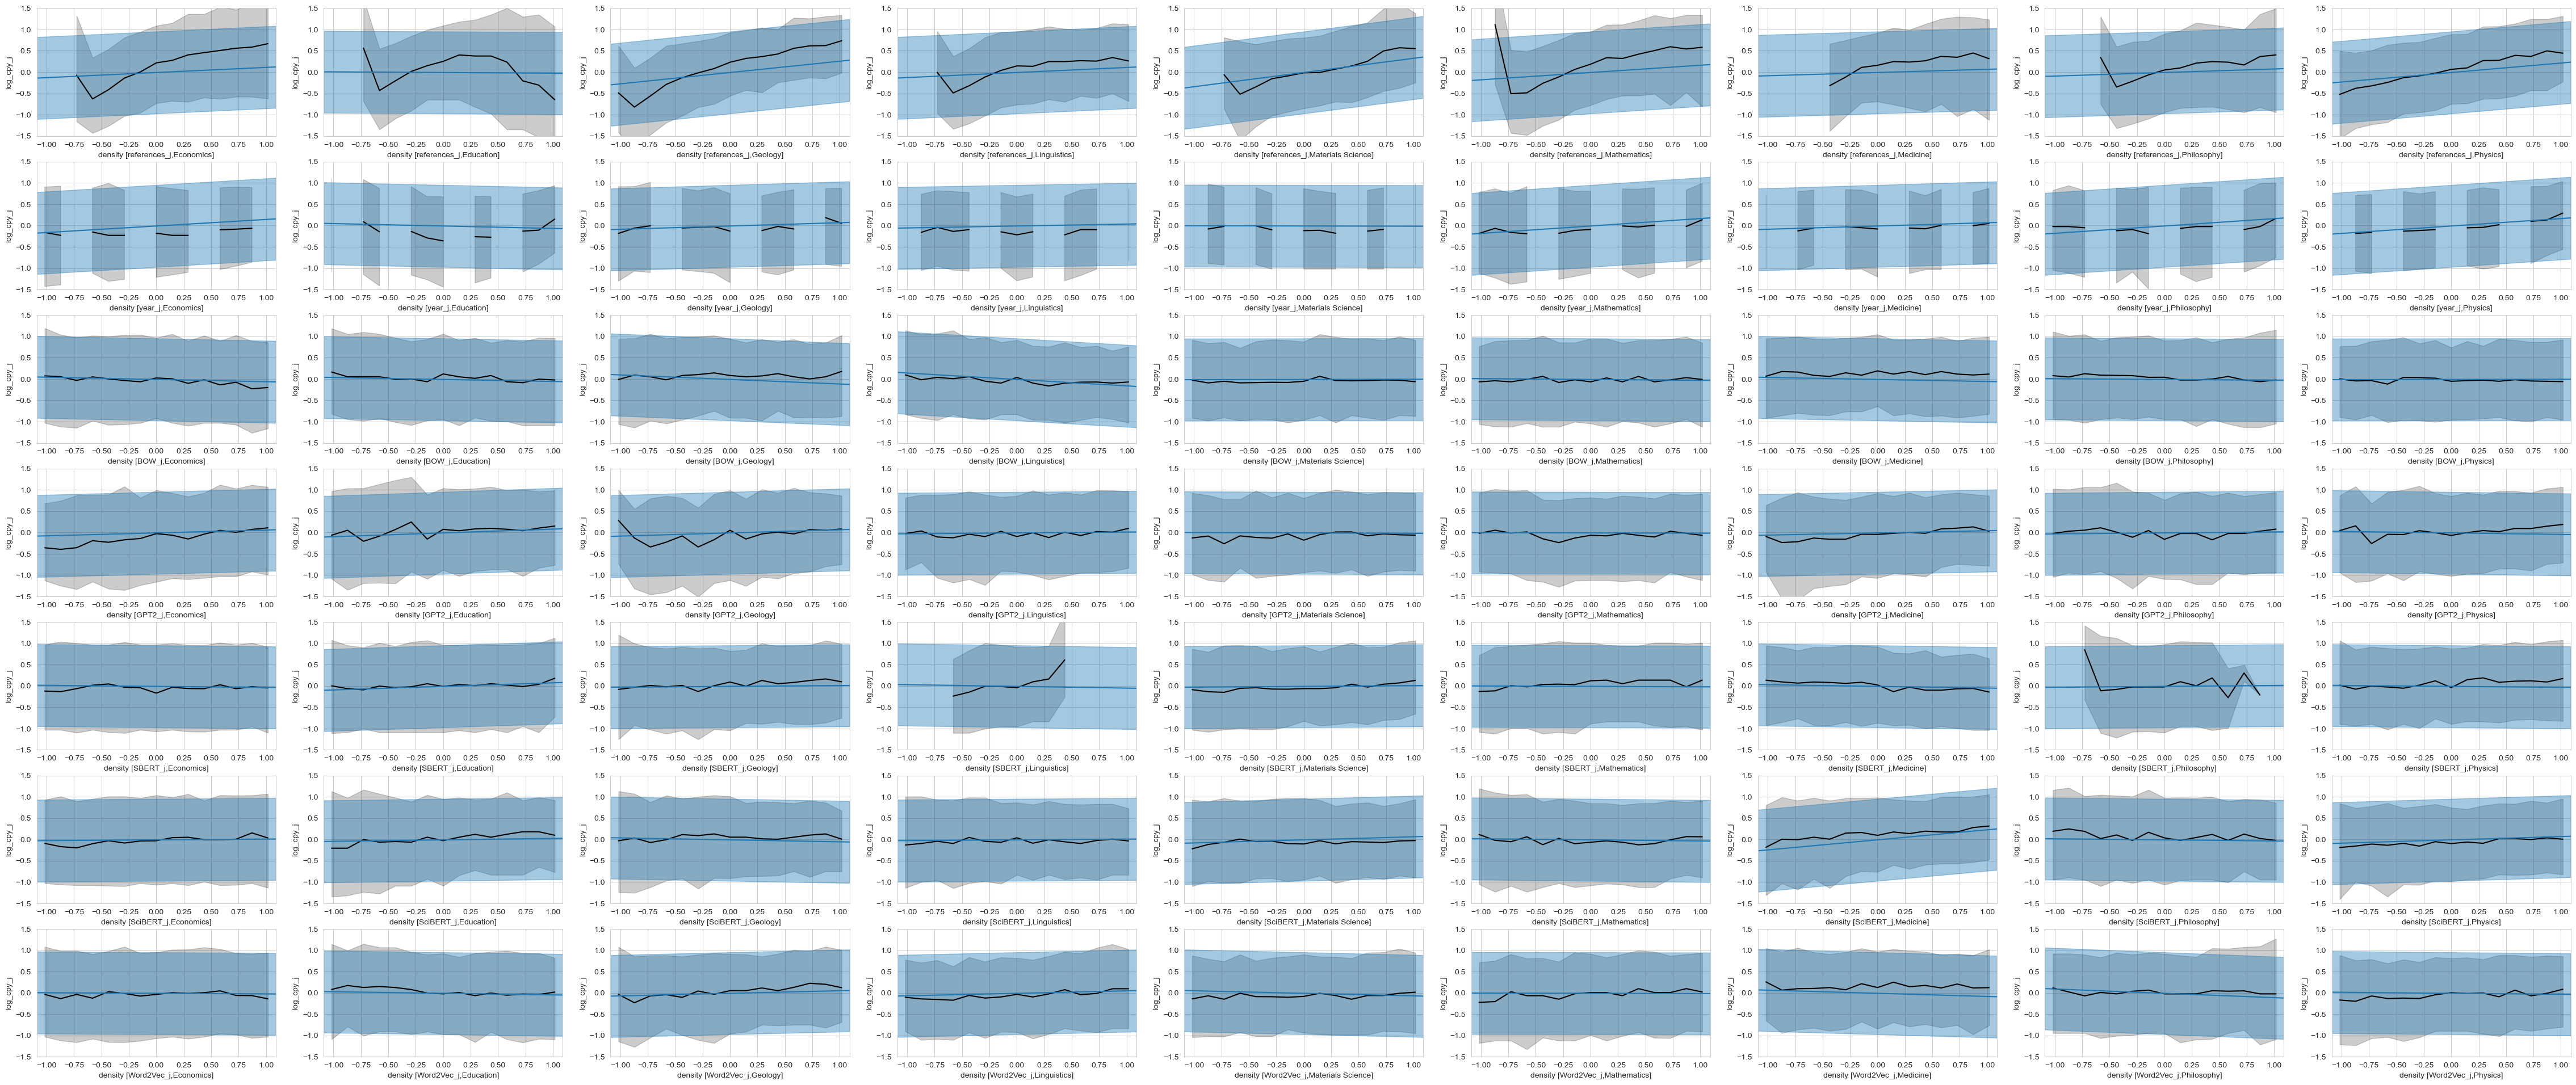

In [86]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(vectorizer_names)))
mosaic = [[f"{fit_col_i}_{field_j}" for field_j in field_names] for fit_col_i in used_fit_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, fit_col_i in enumerate(used_fit_cols):
    for j, field_j in enumerate(field_names):

        ax_key = f"{fit_col_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=fit_col_i,
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = output["alpha"] + output[f"beta[{fit_col_i},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - output["sigma"],
            ys + output["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{fit_col_i},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)
        

# Save

In [87]:
results = pd.DataFrame(results_dict).T

In [88]:
# Where we didn't specify a y column we default to log_cpy
results["y_col"] = results["y_col"].fillna("log_cpy")

In [89]:
# Save results
results.to_csv(f"{config["output_dir"]}/results.csv")

In [90]:
results

alpha beta[BOW] beta[BOW_j,Economics]  \
base                      0.000198       NaN                   NaN   
BOW                      -0.019432  0.088116                   NaN   
GPT2                     -0.014659       NaN                   NaN   
SBERT                     0.000768       NaN                   NaN   
SciBERT                  -0.014481       NaN                   NaN   
Word2Vec                 -0.018119       NaN                   NaN   
nondens                   0.000129       NaN                   NaN   
BOW + nondens            -0.015642  0.068215                   NaN   
GPT2 + nondens           -0.013027       NaN                   NaN   
SBERT + nondens           0.000321       NaN                   NaN   
SciBERT + nondens        -0.011741       NaN                   NaN   
Word2Vec + nondens        -0.01417       NaN                   NaN   
dens + nondens           -0.017667  0.063695                   NaN   
h-BOW_j                  -0.013765       NaN              -0.04747   
h-GPT2_j                 -0.006268       NaN                   NaN   
h-SBERT_j                 0.007001       NaN                   NaN   
h-SciBERT_j              -0.014162       NaN                   NaN   
h-Word2Vec_j             -0.012731       NaN                   NaN   
h-BOW_j + h-nondens      -0.011078       NaN             -0.065027   
h-GPT2_j + h-nondens     -0.004134       NaN                   NaN   
h-SBERT_j + h-nondens     0.005237       NaN                   NaN   
h-SciBERT_j + h-nondens  -0.011133       NaN                   NaN   
h-Word2Vec_j + h-nondens -0.010135       NaN                   NaN   
h-nondens                -0.010169       NaN                   NaN   
h-dens + h-nondens       -0.010662       NaN             -0.052844   

                         beta[BOW_j,Education] beta[BOW_j,Geology]  \
base                                       NaN                 NaN   
BOW                                        NaN                 NaN   
GPT2                                       NaN                 NaN   
SBERT                                      NaN                 NaN   
SciBERT                                    NaN                 NaN   
Word2Vec                                   NaN                 NaN   
nondens                                    NaN                 NaN   
BOW + nondens                              NaN                 NaN   
GPT2 + nondens                             NaN                 NaN   
SBERT + nondens                            NaN                 NaN   
SciBERT + nondens                          NaN                 NaN   
Word2Vec + nondens                         NaN                 NaN   
dens + nondens                             NaN                 NaN   
h-BOW_j                              -0.065634            -0.07196   
h-GPT2_j                                   NaN                 NaN   
h-SBERT_j                                  NaN                 NaN   
h-SciBERT_j                                NaN                 NaN   
h-Word2Vec_j                               NaN                 NaN   
h-BOW_j + h-nondens                  -0.057771           -0.113419   
h-GPT2_j + h-nondens                       NaN                 NaN   
h-SBERT_j + h-nondens                      NaN                 NaN   
h-SciBERT_j + h-nondens                    NaN                 NaN   
h-Word2Vec_j + h-nondens                   NaN                 NaN   
h-nondens                                  NaN                 NaN   
h-dens + h-nondens                   -0.046964           -0.106336   

                         beta[BOW_j,Linguistics]  \
base                                         NaN   
BOW                                          NaN   
GPT2                                         NaN   
SBERT                                        NaN   
SciBERT                                      NaN   
Word2Vec                                     NaN   
nondens                

# Summarize

## Calculate y_pred

In [91]:
# Get the test x values
x_test = df_test[fit_cols].fillna(0.0).values

In [92]:
# Get the contribution to y_pred from the intercept
alphas = results["alpha"].values.reshape(1, -1)

In [93]:
# Get the coefficients for regular regression
# and the contribution to y_pred from the regular regression
beta_cols = [f"beta[{fit_col}]" for fit_col in fit_cols]
betas = results[beta_cols].fillna(0.0).values
y_pred_beta = np.matmul(x_test, betas.T)

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/734696789.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  betas = results[beta_cols].fillna(0.0).values


In [94]:
# Calculate and format y_pred (without the hierarchical reg contribution)
y_pred = alphas + y_pred_beta
y_pred = pd.DataFrame(y_pred, index=df_test.index, columns=results.index)

In [95]:
# Get the contribution to y_pred from hierarchical regression
n_tot = 0
for i, field_i in enumerate(field_names):
    # Get the x values
    df_test_i = df_test.query(f"stan_field_code == {i + 1}")
    x_test_i = df_test_i[used_fit_cols].fillna(0.0).values

    # Get the slopes used for this particular field
    beta_cols_i = [
        f"beta[{fit_col_j},{field_i}]" for fit_col_j in used_fit_cols
    ]
    betas_j = results[beta_cols_i].fillna(0.0).values

    # Get y_pred and store it
    y_pred_beta_i = np.matmul(x_test_i, betas_j.T)
    y_pred.loc[df_test_i.index] += y_pred_beta_i

    # Keep track of n_tot as a double check that every observation has a contribution
    # from their primary field
    n_tot += len(y_pred_beta_i)

assert n_tot == len(df_test), "y_pred count doesn't match"

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/522477326.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  betas_j = results[beta_cols_i].fillna(0.0).values
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/522477326.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  betas_j = results[beta_cols_i].fillna(0.0).values
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/522477326.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future versio

In [96]:
# Calculate original non-scaled y_pred
y_pred_orig = y_pred.copy()
y_pred_orig = y_pred_orig.set_index([df_test["stan_field_code"], y_pred_orig.index]).sort_index()
for i, field_i in enumerate(field_names):
    y_pred_i = y_pred_orig.loc[i+1].copy()
    for j, model_j in enumerate(results.index):
        if results.loc[model_j,"y_col"] == "log_cpy":
            scaler_used = scaler
        if results.loc[model_j,"y_col"] == "log_cpy_j":
            scaler_used = scalers[i+1]
        y_pred_orig_ij = scaler_used.scale_[0] * y_pred_i[model_j] + scaler_used.mean_[0]
        y_pred_i[model_j] = y_pred_orig_ij
    y_pred_orig.loc[i+1] = y_pred_i.values

# Put the entries back where we found them
y_pred_orig = y_pred_orig.reset_index().set_index("identifier").loc[y_pred.index]
y_pred_orig = y_pred_orig.drop("stan_field_code", axis="columns")
y_pred_orig


base       BOW      GPT2  \
identifier                                                               
d978a2745a6db38ac0a239142e83776b106a7432  0.516603  0.483671  0.506558   
42205caf56106b124535dbf27c03dc8888fd2f68  0.516603   0.62923  0.649777   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91  0.516603    0.4972  0.459981   
547428e5be12cce266974121ac4c32d35510f28d  0.516603  0.461877  0.481577   
647bf7037000ca138e09528f207253d2d85033c6  0.516603   0.50333  0.506558   
...                                            ...       ...       ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.516603   0.50692  0.580903   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382  0.516603  0.483265  0.519813   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.516603  0.497356  0.538608   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636  0.516603  0.491759  0.417502   
c0c42b2b21df2944f1847e024624a87f293842ff  0.516603  0.472667  0.392897   

                                             SBERT   SciBERT  Word2Vec  \
identifier                                                               
d978a2745a6db38ac0a239142e83776b106a7432  0.516988  0.524123  0.503592   
42205caf56106b124535dbf27c03dc8888fd2f68  0.579771  0.531796  0.553995   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91  0.499981  0.482021  0.500841   
547428e5be12cce266974121ac4c32d35510f28d   0.49386  0.449043    0.4703   
647bf7037000ca138e09528f207253d2d85033c6  0.500871  0.506678  0.504218   
...                                            ...       ...       ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.546612   0.53233  0.494683   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382   0.50224   0.47562  0.462594   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.527076  0.508279  0.545481   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636  0.516988  0.525353  0.497103   
c0c42b2b21df2944f1847e024624a87f293842ff  0.511013  0.518946  0.500135   

                                           nondens BOW + nondens  \
identifier                                                         
d978a2745a6db38ac0a239142e83776b106a7432  0.772403      0.785051   
42205caf56106b124535dbf27c03dc8888fd2f68  0.556395      0.650909   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91  0.638712        0.6518   
547428e5be12cce266974121ac4c32d35510f28d  0.382155      0.333618   
647bf7037000ca138e09528f207253d2d85033c6  0.475321      0.458675   
...                                            ...           ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.595702      0.591897   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382  0.483564      0.450077   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.547579      0.524218   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636   0.38347       0.34484   
c0c42b2b21df2944f1847e024624a87f293842ff  0.484186       0.44604   

                                         GPT2 + nondens SBERT + nondens  ...  \
identifier                                                               ...   
d978a2745a6db38ac0a239142e83776b106a7432       0.738686        0.745374  ...   
42205caf56106b124535dbf27c03dc8888fd2f68       0.670317        0.599491  ...   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91       0.575482        0.609903  ...   
547428e5be12cce266974121ac4c32d35510f28d       0.362423        0.374615  ...   
647bf7037000ca138e09528f207253d2d85033c6       0.470399        0.467511  ...   
...                                                 ...             ...  ...   
be330267c027ffbb3d8fabf3e854b178681a62e6       0.645942        0.612307  ...   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382       0.489894        0.476689  ...   
23775d0440d967d1f8c6f59f3815c5bac9829c63       0.565606        0.555925  ...   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636        0.30846        0.397414  ...   
c0c42b2b21df2944f1847e024624a87f293842ff       0.377594        0.482869  ...   

                                         h-SBERT_j h-SciBERT_j h-Word2Vec_j  \
identifier                                                                    
d978a2745a6db38ac0a239142e83776b106a

In [97]:
y_pred

base       BOW      GPT2  \
identifier                                                               
d978a2745a6db38ac0a239142e83776b106a7432  0.000198 -0.048507 -0.014659   
42205caf56106b124535dbf27c03dc8888fd2f68  0.000198  0.166773  0.197161   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91  0.000198 -0.028499 -0.083545   
547428e5be12cce266974121ac4c32d35510f28d  0.000198 -0.080741 -0.051605   
647bf7037000ca138e09528f207253d2d85033c6  0.000198 -0.019432 -0.014659   
...                                            ...       ...       ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.000198 -0.014123  0.095298   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382  0.000198 -0.049109  0.004946   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.000198 -0.028268  0.032744   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636  0.000198 -0.036546 -0.146371   
c0c42b2b21df2944f1847e024624a87f293842ff  0.000198 -0.064783 -0.182761   

                                             SBERT   SciBERT  Word2Vec  \
identifier                                                               
d978a2745a6db38ac0a239142e83776b106a7432  0.000768   0.01132 -0.019045   
42205caf56106b124535dbf27c03dc8888fd2f68  0.093623  0.022669  0.055501   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91 -0.024386 -0.050948 -0.023113   
547428e5be12cce266974121ac4c32d35510f28d -0.033438 -0.099722 -0.068284   
647bf7037000ca138e09528f207253d2d85033c6 -0.023069 -0.014481 -0.018119   
...                                            ...       ...       ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.044581  0.023459 -0.032221   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382 -0.021044 -0.060416 -0.079681   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.015688 -0.012113  0.042909   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636  0.000768   0.01314 -0.028642   
c0c42b2b21df2944f1847e024624a87f293842ff -0.008069  0.003663 -0.024158   

                                           nondens BOW + nondens  \
identifier                                                         
d978a2745a6db38ac0a239142e83776b106a7432  0.378525      0.397231   
42205caf56106b124535dbf27c03dc8888fd2f68  0.059051      0.198836   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91  0.180797      0.200154   
547428e5be12cce266974121ac4c32d35510f28d  -0.19865     -0.270436   
647bf7037000ca138e09528f207253d2d85033c6 -0.060858     -0.085478   
...                                            ...           ...   
be330267c027ffbb3d8fabf3e854b178681a62e6  0.117186      0.111558   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382 -0.048665     -0.098193   
23775d0440d967d1f8c6f59f3815c5bac9829c63  0.046011      0.011461   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636 -0.196705     -0.253838   
c0c42b2b21df2944f1847e024624a87f293842ff -0.047747     -0.104164   

                                         GPT2 + nondens SBERT + nondens  ...  \
identifier                                                               ...   
d978a2745a6db38ac0a239142e83776b106a7432       0.328657        0.338549  ...   
42205caf56106b124535dbf27c03dc8888fd2f68        0.22754         0.12279  ...   
4a92e318eff6cb13a1654e2b2ca7b393a3bbcd91        0.08728        0.138189  ...   
547428e5be12cce266974121ac4c32d35510f28d      -0.227832       -0.209801  ...   
647bf7037000ca138e09528f207253d2d85033c6      -0.068138       -0.072409  ...   
...                                                 ...             ...  ...   
be330267c027ffbb3d8fabf3e854b178681a62e6        0.19149        0.141744  ...   
65b3b7618816b225e32905b0a9bdcf4b9dd7e382      -0.039304       -0.058835  ...   
23775d0440d967d1f8c6f59f3815c5bac9829c63       0.072674        0.058355  ...   
7e5d8acdc2a18b20b0c1124d9acdbbe0560e3636      -0.307643       -0.176081  ...   
c0c42b2b21df2944f1847e024624a87f293842ff      -0.205394       -0.049693  ...   

                                         h-SBERT_j h-SciBERT_j h-Word2Vec_j  \
identifier                                                                    
d978a2745a6db38ac0a239142e83776b106a

## Basic metrics

### Log Posterior Predictive Density

Text(0, 0.5, 'PPD $\\log$ likelihood ratio')

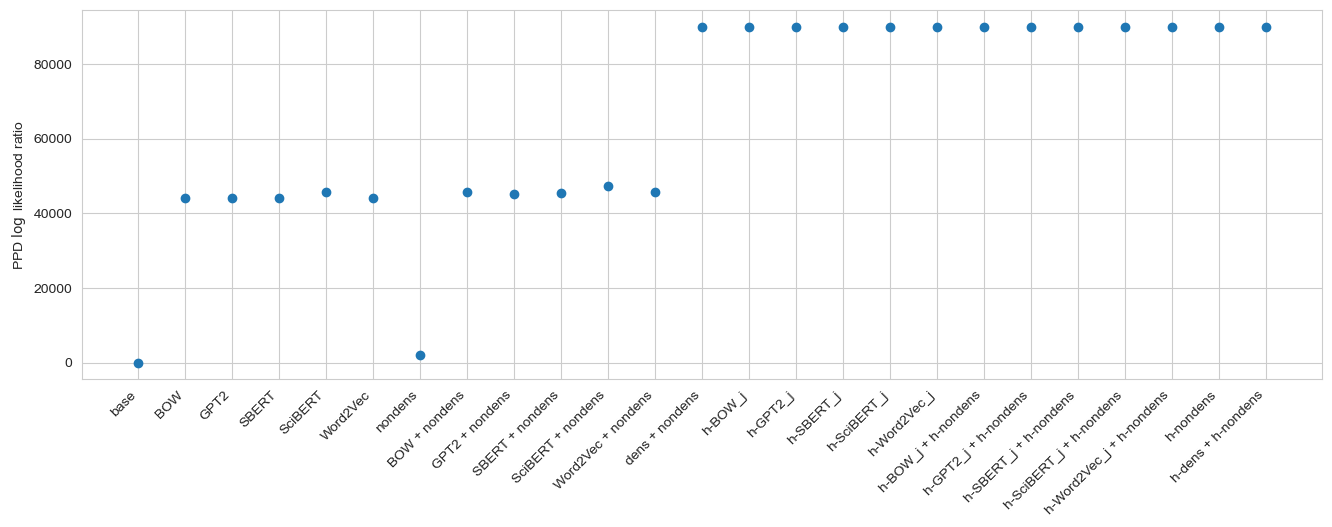

In [98]:
fig = plt.figure(figsize=(6.4 * len(results) / 10, 4.8))
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["log_ppd"] - results.loc["base", "log_ppd"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")

ax.set_ylabel(r"PPD $\log$ likelihood ratio")

### RMSE

In [99]:
# Calculate rmse
rmse = []
for i, y_col_i in enumerate(results["y_col"]):
    model_i = results.index[i]
    rmse_i = root_mean_squared_error(df_test[y_col_i], y_pred[model_i])
    rmse.append(rmse_i)
results["rmse"] = rmse

Text(0, 0.5, 'rmse')

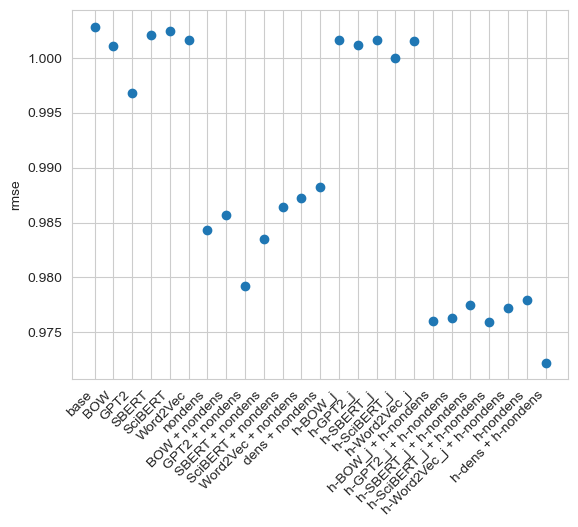

In [100]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["rmse"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel("rmse")

### Maximum slopes

In [101]:
max_betas = results[beta_cols].max(axis="columns")

(0.0, 0.1937994875)

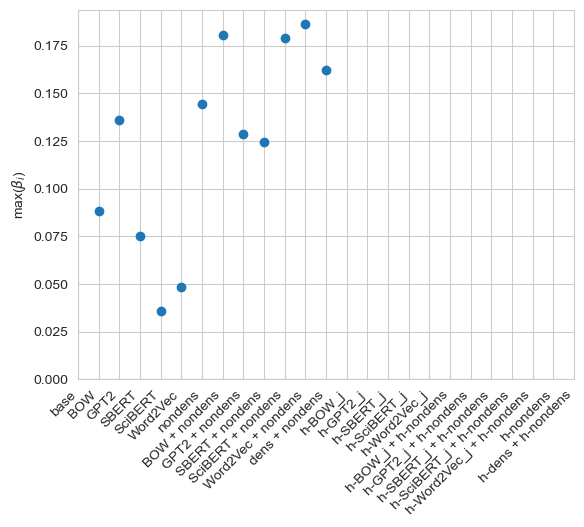

In [102]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    max_betas,
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel(r"max($\beta_i$)")

ax.set_ylim(0, ax.get_ylim()[1])

Text(0, 0.5, '1 - rmse')

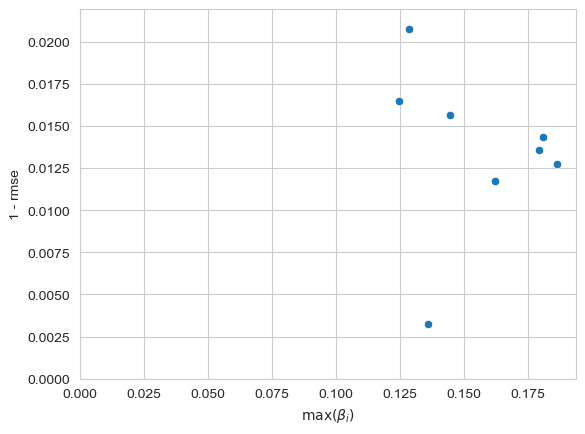

In [103]:
# max slopes correlation with rmse
ax = sns.scatterplot(
    results,
    x=max_betas,
    y=1 - results["rmse"],
)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.set_xlabel(r"$\max(\beta_i)$")
ax.set_ylabel(r"1 - rmse")

### RMSE vs distance from center

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/2717996565.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_test_to_group.groupby(cut_key)
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/2717996565.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_y_pred = df_grouped.apply(get_mean_y_pred)
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_91695/2717996565.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 

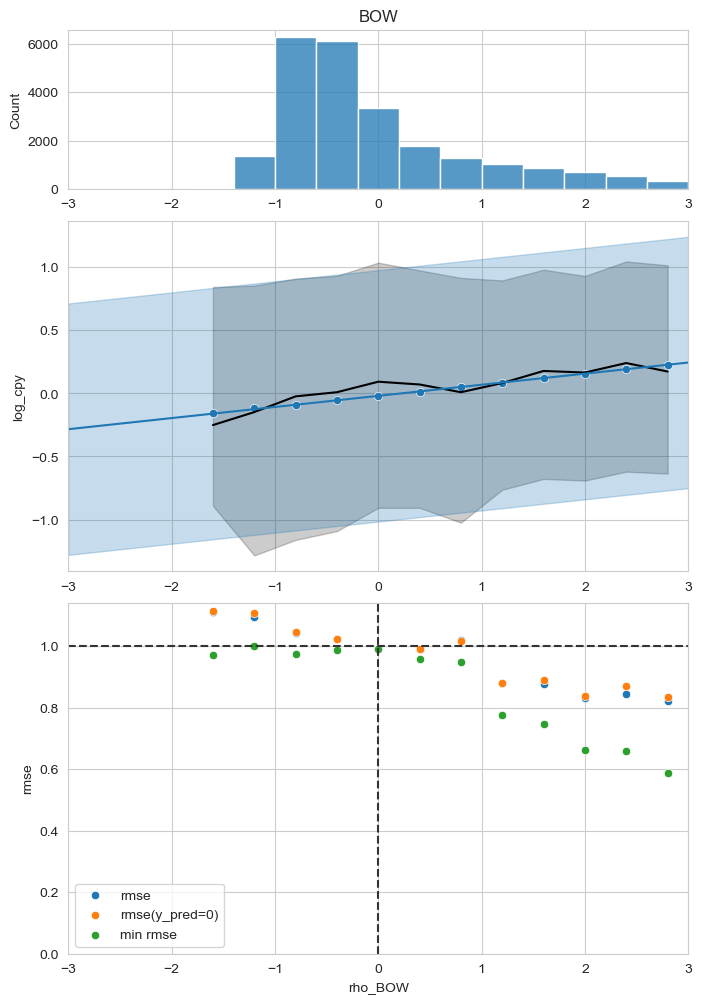

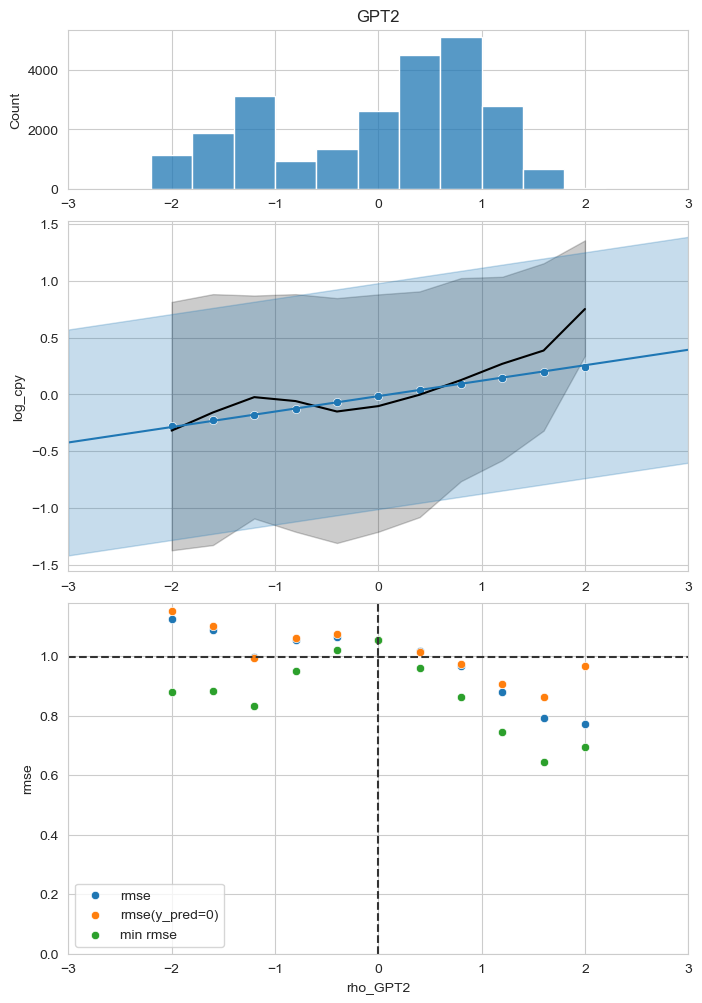

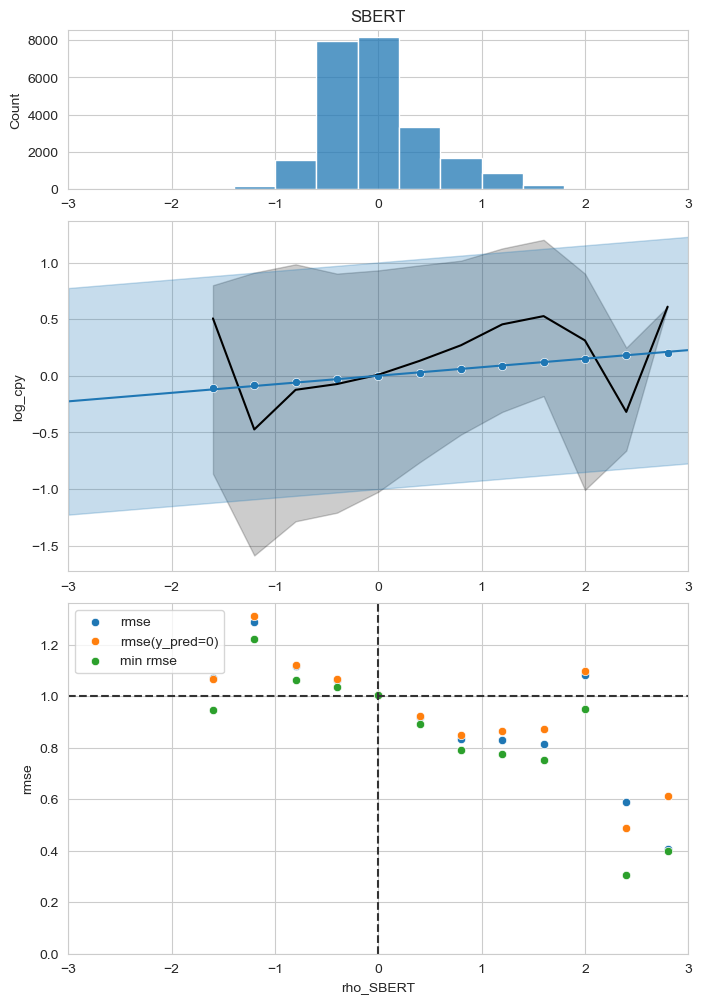

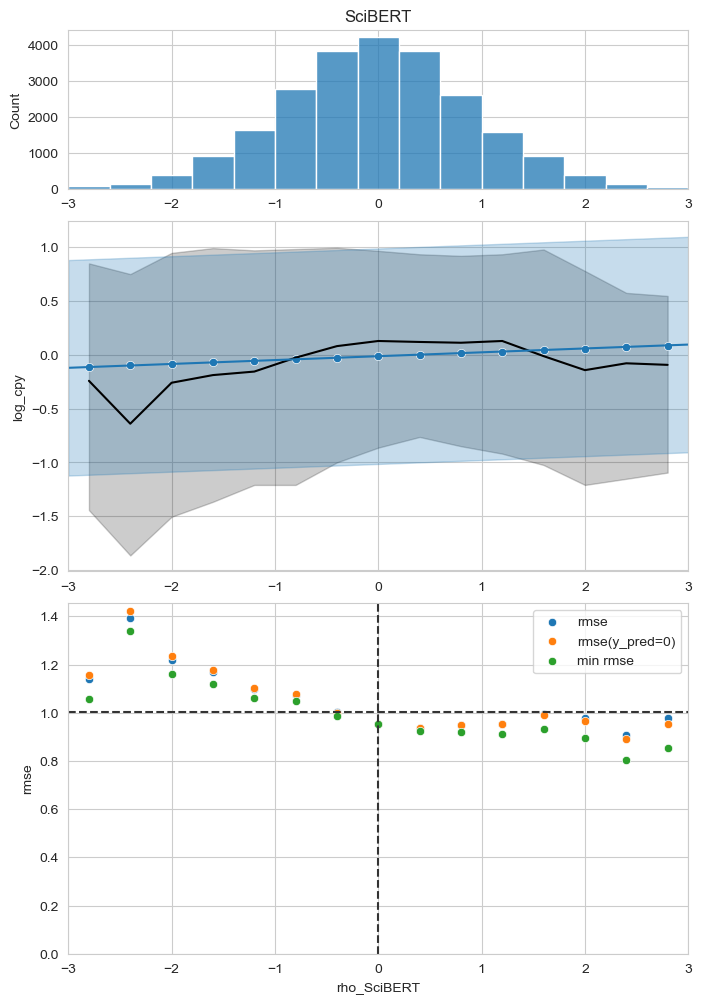

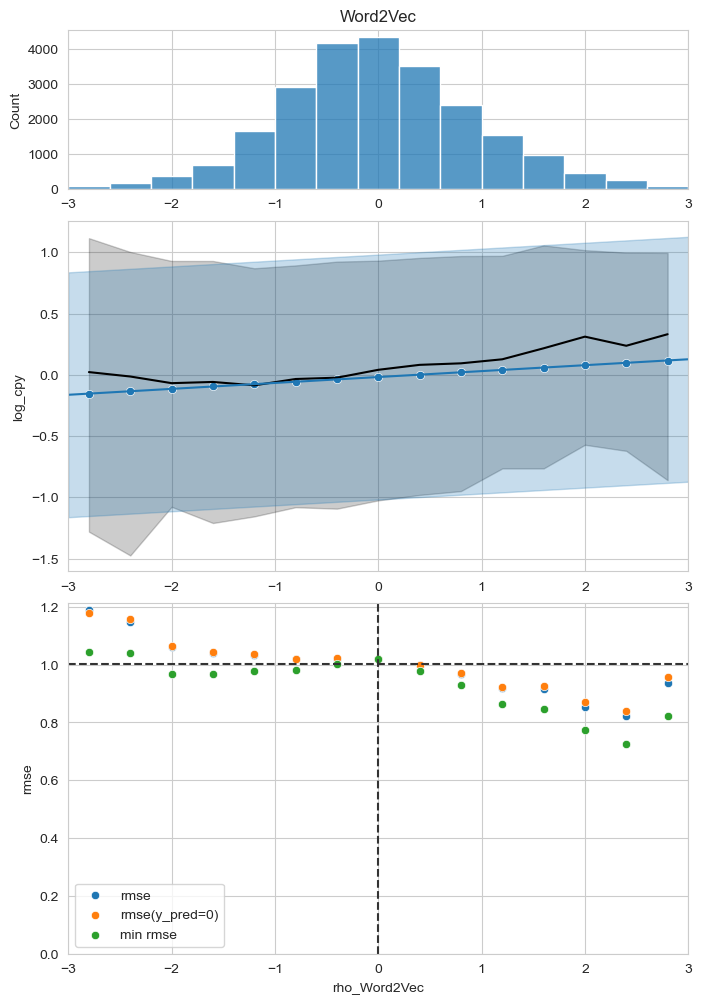

In [104]:
# Inspect rmse as a function of distance from the center
for model_i in results.index:

    row = results.loc[model_i]

    # Only do models that have a density dependence
    try:
        vectorizer_i = model_i.split("_")[-1]
        assert vectorizer_i in vectorizer_names
    except AssertionError:
        continue

    # Bin and labels setup
    bins = np.linspace(-3, 3, config["bins"])
    centers = 0.5 * (bins[:-1] + bins[1:])
    den_key = f"rho_{vectorizer_i}"
    cut_key = f"{den_key}_bin"
    model_key = f"y_pred_{model_i}"

    # Format data into a new df and group it
    df_test_to_group = pd.DataFrame()
    df_test_to_group[den_key] = df_test[vectorizer_i]
    df_test_to_group[model_key] = y_pred[model_i]
    df_test_to_group[cut_key] = pd.cut(df_test_to_group[den_key], bins)
    df_test_to_group["y_test"] = df_test[row["y_col"]]
    df_grouped = df_test_to_group.groupby(cut_key)

    # Get mean predicted y per bin
    def get_mean_y_pred(df):
        if len(df) == 0:
            return np.nan
        return df[model_key].mean()

    mean_y_pred = df_grouped.apply(get_mean_y_pred)

    # Get rmse
    def get_rmse_of_df(df):
        if len(df) == 0:
            return np.nan
        return root_mean_squared_error(df["y_test"], df[model_key])

    rmse_per_bin = df_grouped.apply(get_rmse_of_df)

    # Also get rmse if y_pred was just the mean
    def get_rmse_from_mean(df):
        if len(df) == 0:
            return np.nan
        y_pred = np.zeros(len(df))  # Since we normalized to 0
        return root_mean_squared_error(df["y_test"], y_pred)

    rmse_from_mean = df_grouped.apply(get_rmse_from_mean)

    # And rmse expected if it was a straight improvement on the mean that scales with
    # slope
    min_rmse = rmse_from_mean - np.abs(centers * row[f"beta[{vectorizer_i}]"])

    # Plot
    fig, ax_dict = plt.subplot_mosaic(
        [
            [
                "hist",
            ],
            [
                "reg",
            ],
            [
                "reg",
            ],
            [
                "rmse",
            ],
            [
                "rmse",
            ],
        ],
        figsize=(8, 12),
    )

    # Hist plot
    ax = ax_dict["hist"]
    sns.histplot(
        x=df_test_to_group[den_key],
        ax=ax,
        bins=bins,
    )
    ax.set_xlim(bins[0], bins[-1])
    ax.set_title(model_i)
    ax.set_xlabel(None)

    # Regression plot
    ax = ax_dict["reg"]

    # Plot the median
    medianplot(
        data=df_test_to_group,
        x=den_key,
        y="y_test",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{vectorizer_i}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.25,
    )

    # Plot what y_pred actually is
    ax = sns.scatterplot(
        x=centers,
        y=mean_y_pred,
        ax=ax,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("log_cpy")

    # RMSE plot
    ax = ax_dict["rmse"]
    ax = sns.scatterplot(
        x=centers,
        y=rmse_per_bin,
        ax=ax,
        label="rmse",
    )
    ax = sns.scatterplot(x=centers, y=rmse_from_mean, ax=ax, label="rmse(y_pred=0)")
    ax = sns.scatterplot(x=centers, y=min_rmse, ax=ax, label="min rmse")
    ax.legend()
    # Center line
    ax.axvline(
        0,
        c="0.2",
        linestyle="--",
    )
    # Global rmse line
    ax.axhline(
        results.loc[model_i, "rmse"],
        c="0.2",
        linestyle="--",
    )

    ax.set_ylabel("rmse")
    ax.set_xlabel(den_key)

    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, ax.get_ylim()[1])
    fig

The issue is that RMSE is capturing two behaviors: distance from the mean and also width of the distribution.
The width of the distribution largely dominates over the distance from the mean.
So instead we may want a metric that is an evaluation of the distance median.
This might relate to Nathaniel's choice to bin.

## Many metrics

In [105]:
metrics = {
    r"$R^2$": sk_metrics.r2_score,
    "1-MAE": lambda y_true, y_pred: 1 - sk_metrics.mean_absolute_error(y_true, y_pred),
    "1-RMSE": lambda y_true, y_pred: 1
    - sk_metrics.root_mean_squared_error(y_true, y_pred),
    "1-MAPE": lambda y_true, y_pred: 1
    - sk_metrics.mean_absolute_percentage_error(y_true, y_pred),
    "1-MedAE": lambda y_true, y_pred: 1
    - sk_metrics.median_absolute_error(y_true, y_pred),
    "1-MPinL": lambda y_true, y_pred: 1 - sk_metrics.mean_pinball_loss(y_true, y_pred),
    r"$D^2_{pin}$": sk_metrics.d2_pinball_score,
    r"$D^2_{abs}$": sk_metrics.d2_absolute_error_score,
}

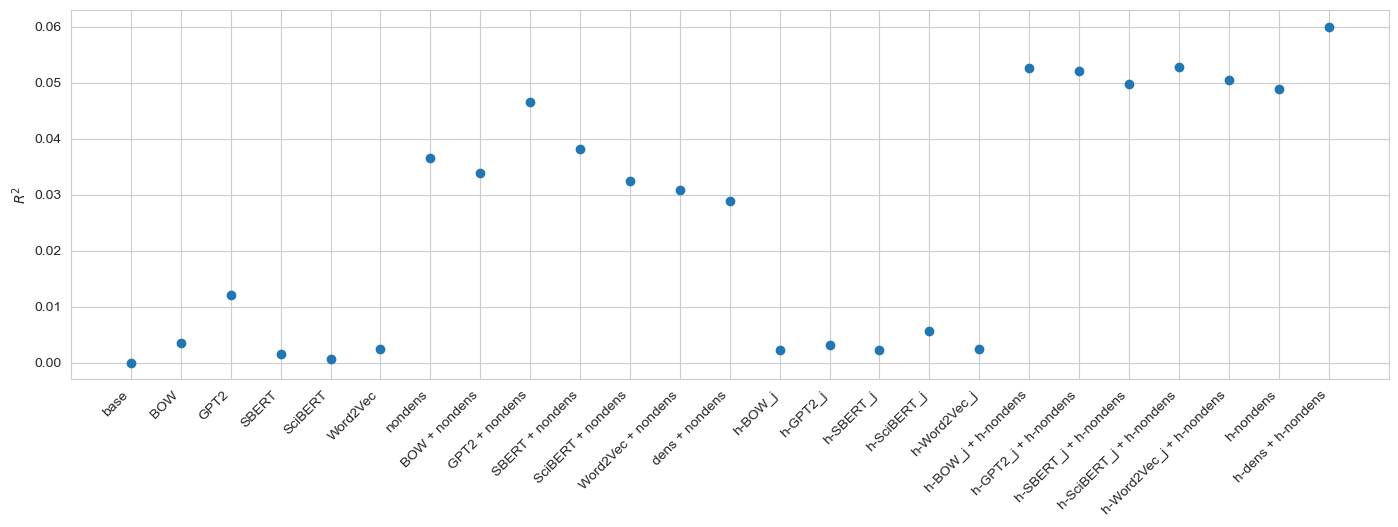

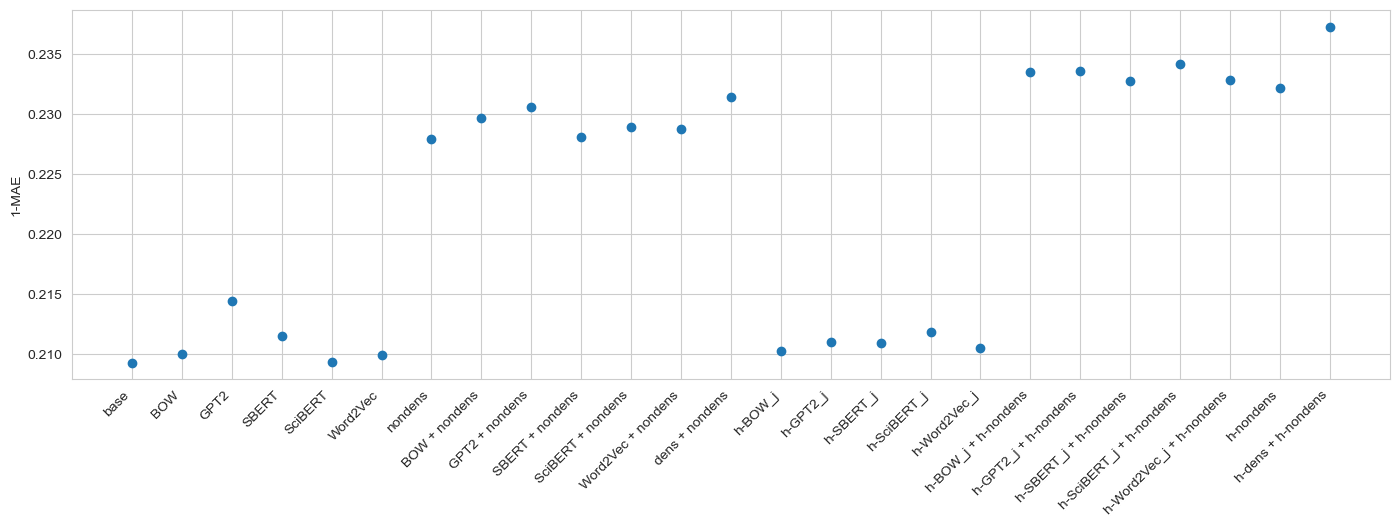

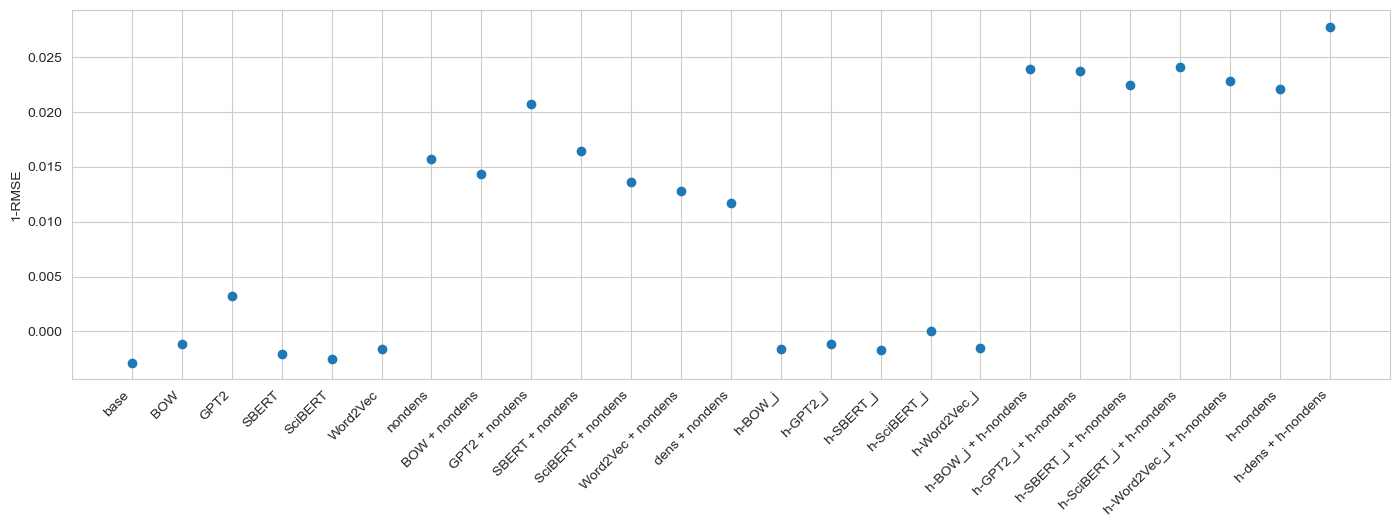

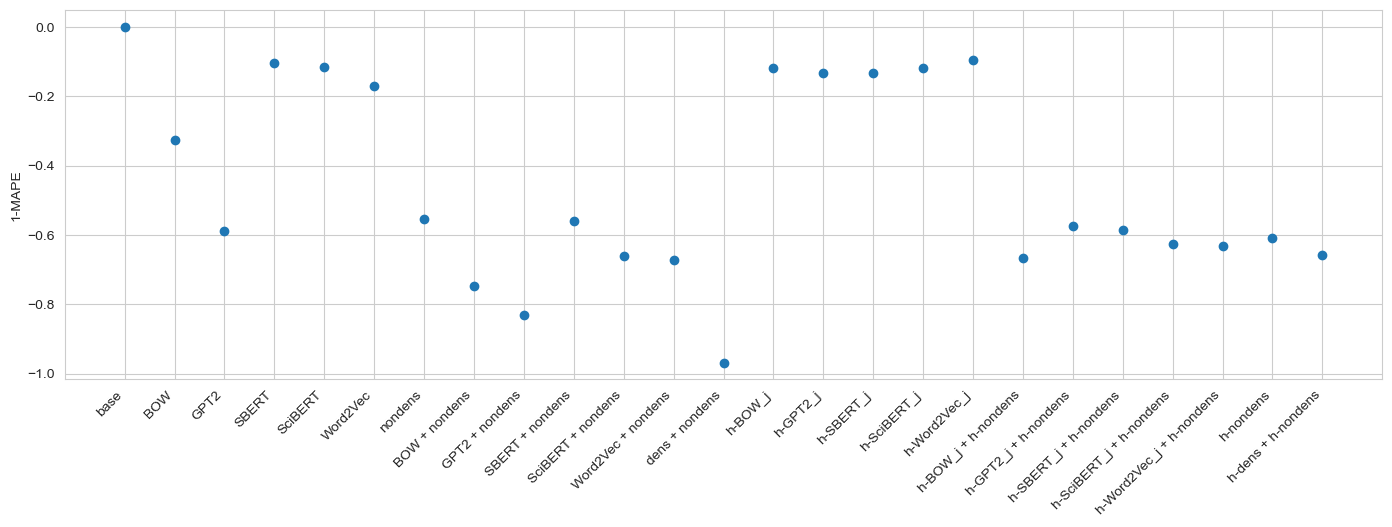

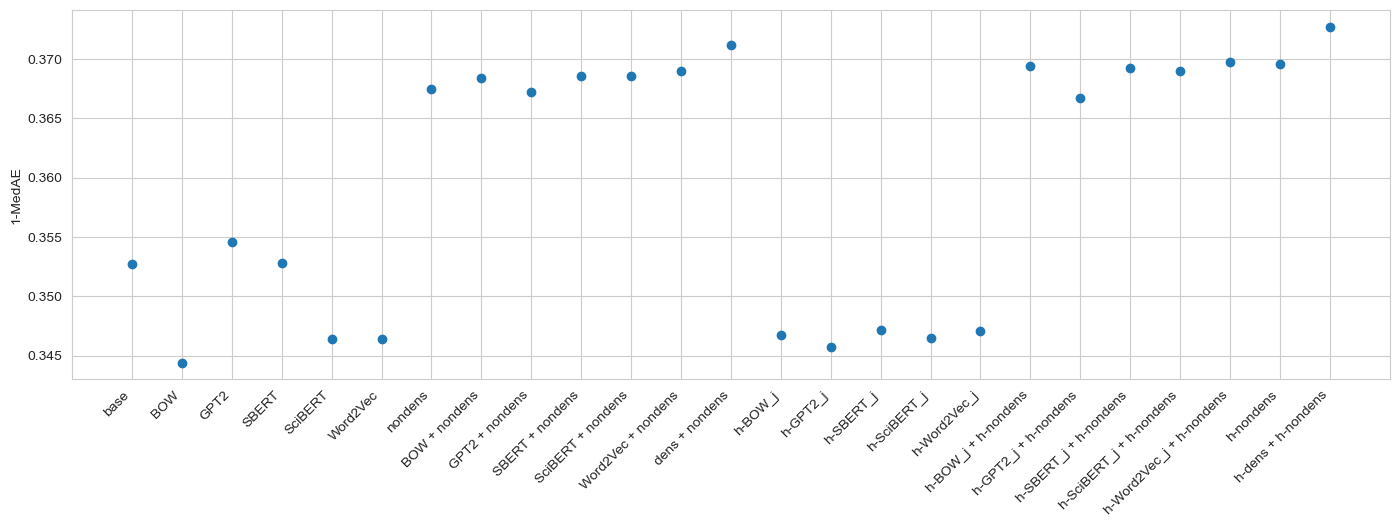

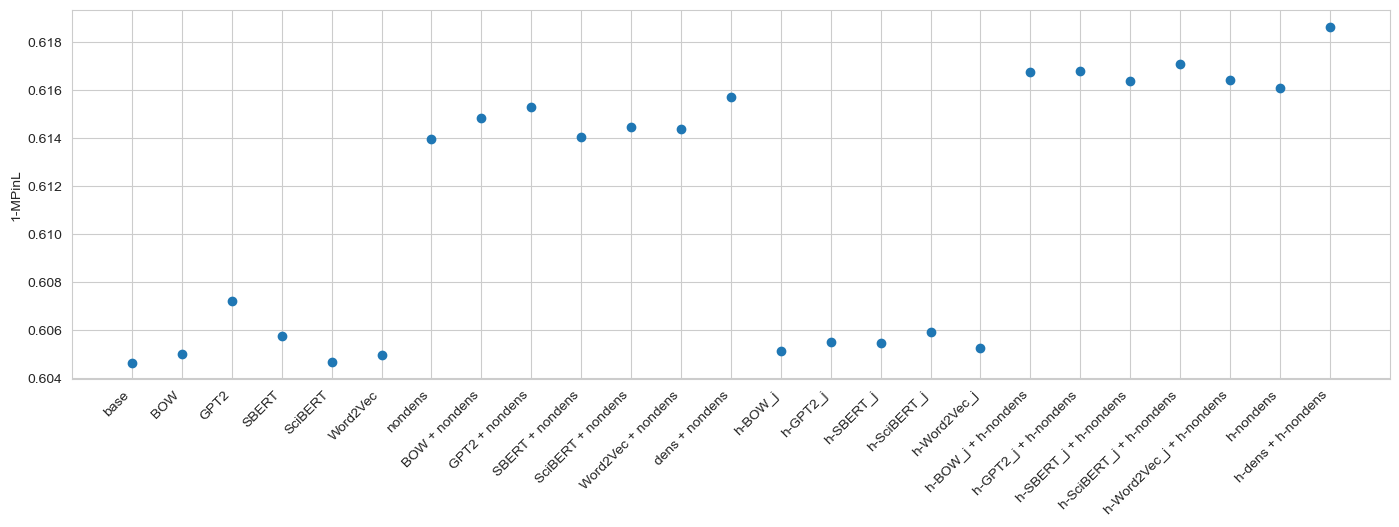

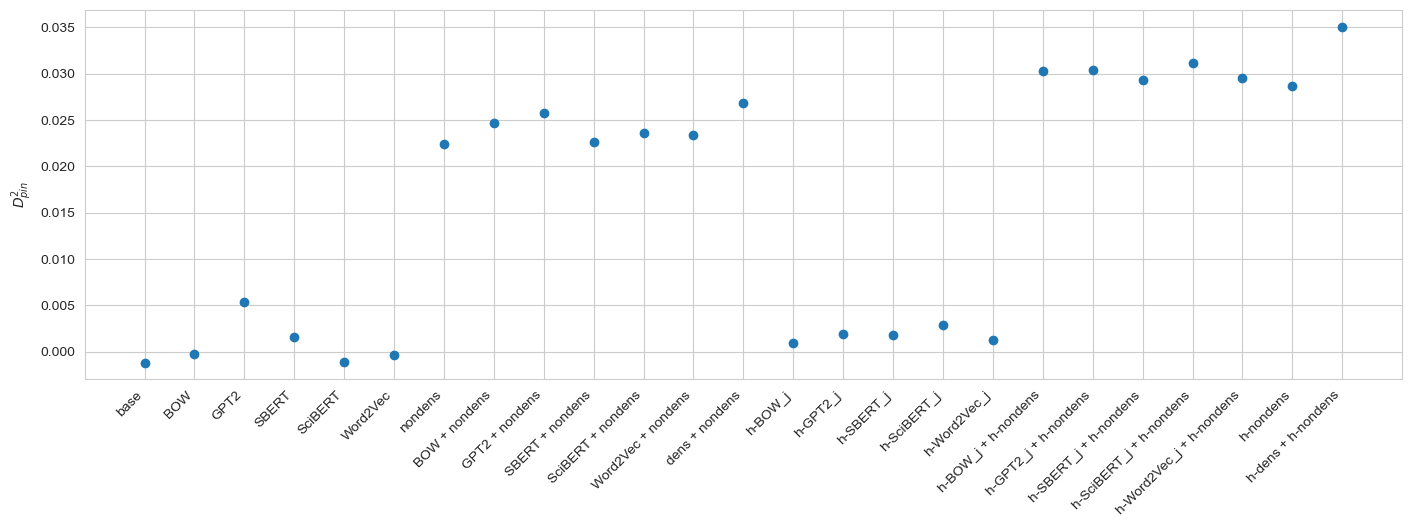

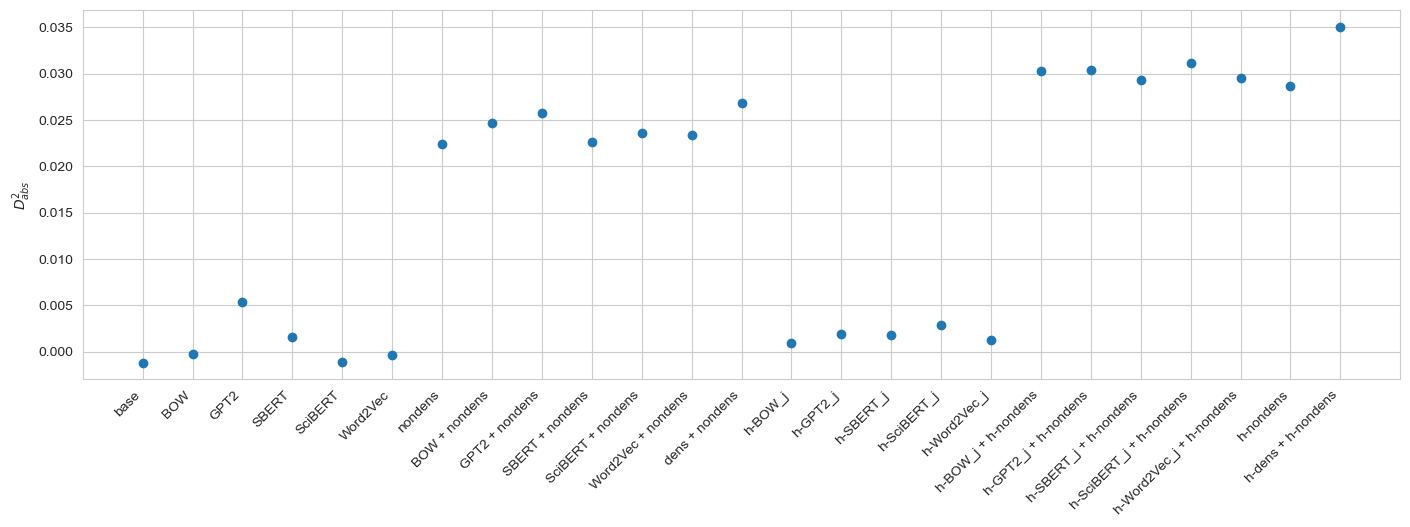

In [106]:
for metric_label, metric_fn in metrics.items():

    # Calculate the metric
    metric = []
    for i, model_i in enumerate(results.index):
        metric_i = metric_fn(df_test[results.loc[model_i, "y_col"]], y_pred[model_i])
        metric.append(metric_i)

    # Plot
    fig = plt.figure(figsize=(6.8 * len(results) / 10, 4.8))
    ax = plt.gca()

    x = np.arange(len(results))
    ax.scatter(
        x,
        metric,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(results.index, rotation=45, ha="right")
    ax.set_ylabel(metric_label)

## Many metrics rescaled
Back in original units

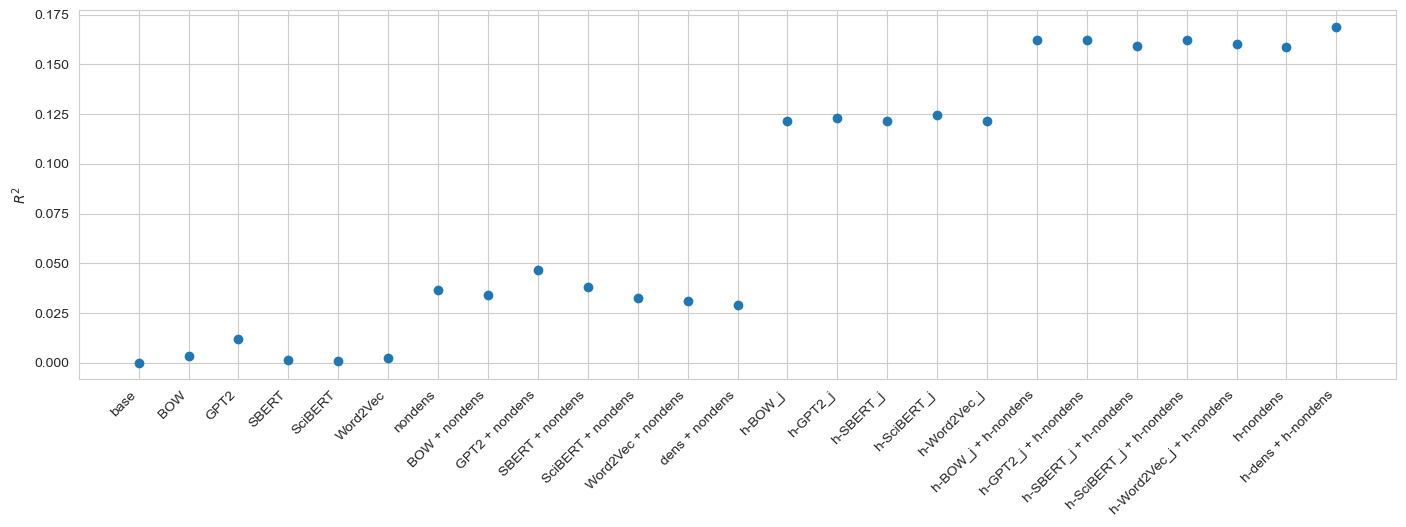

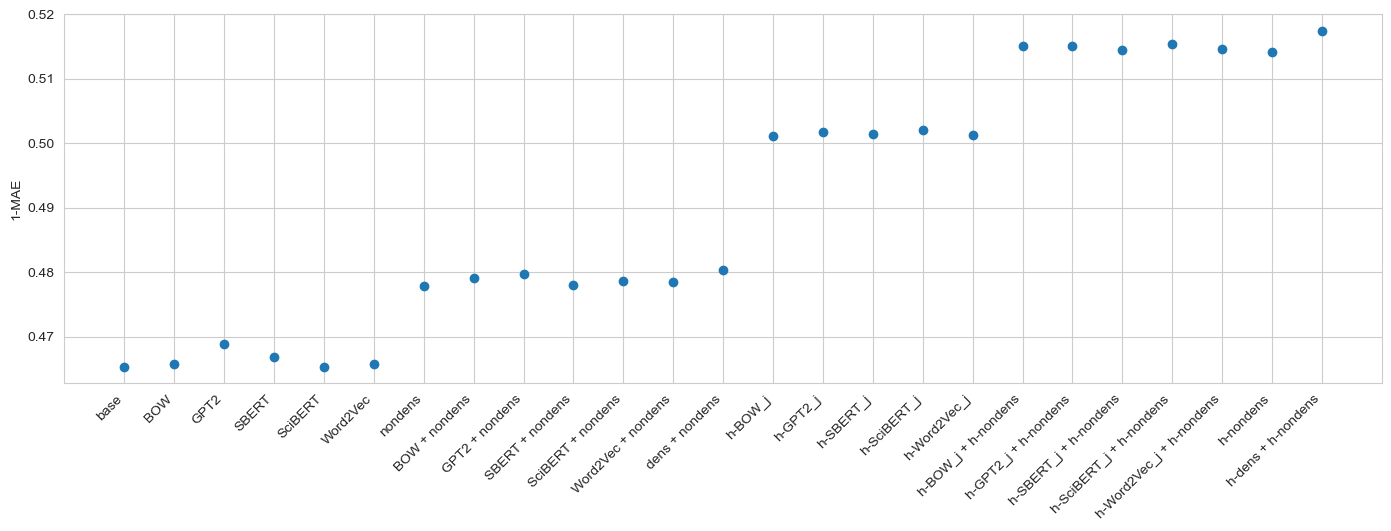

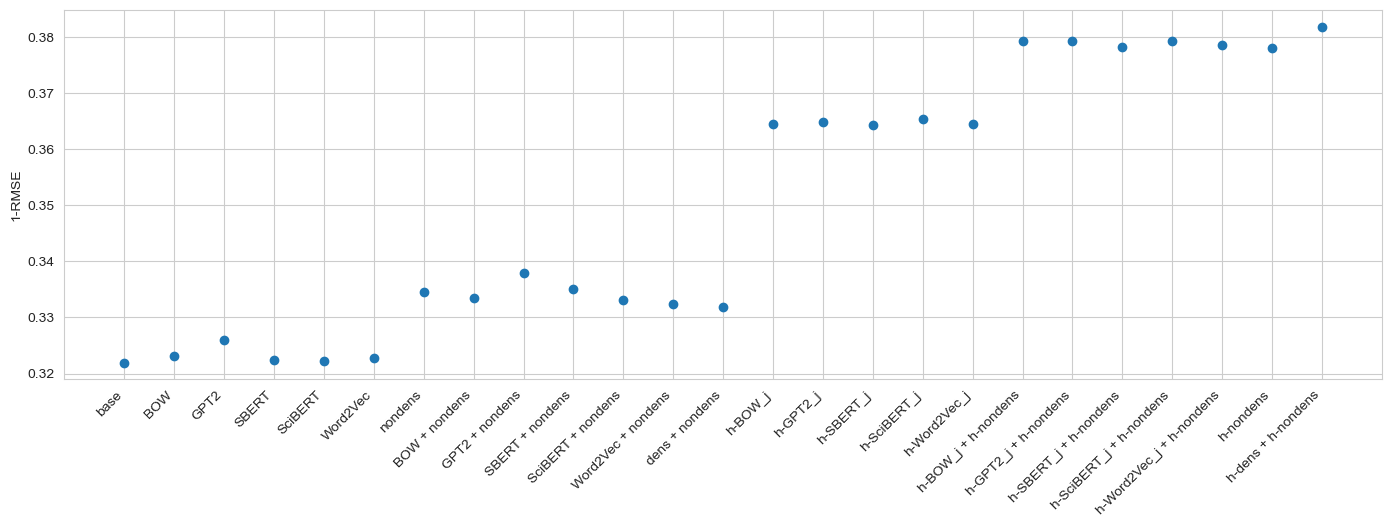

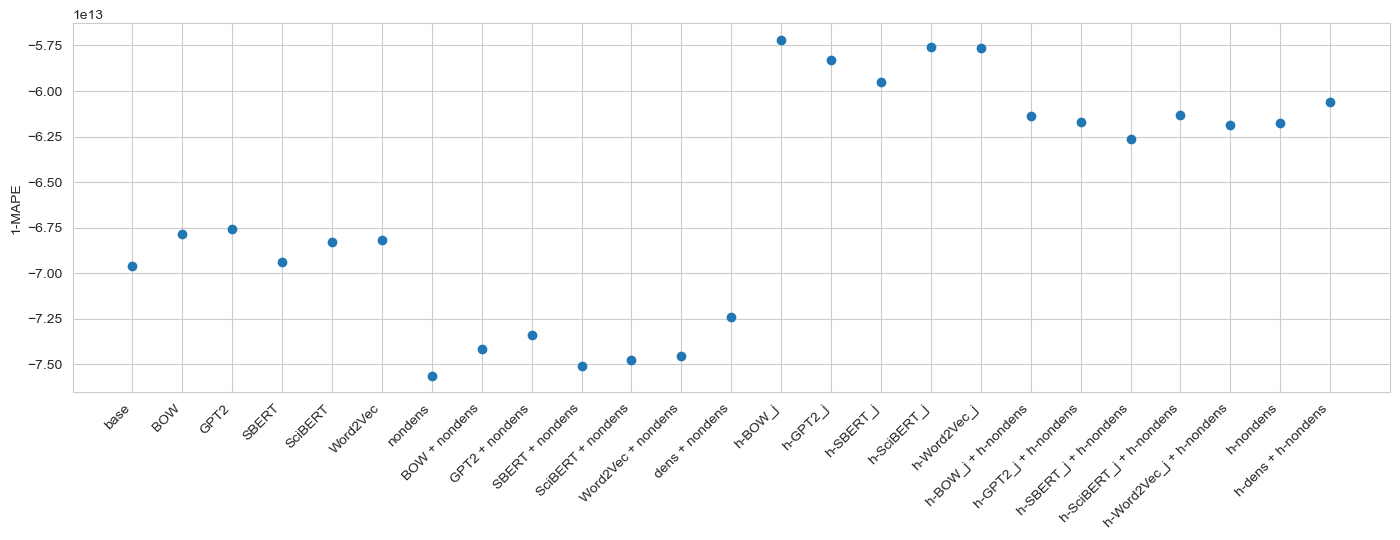

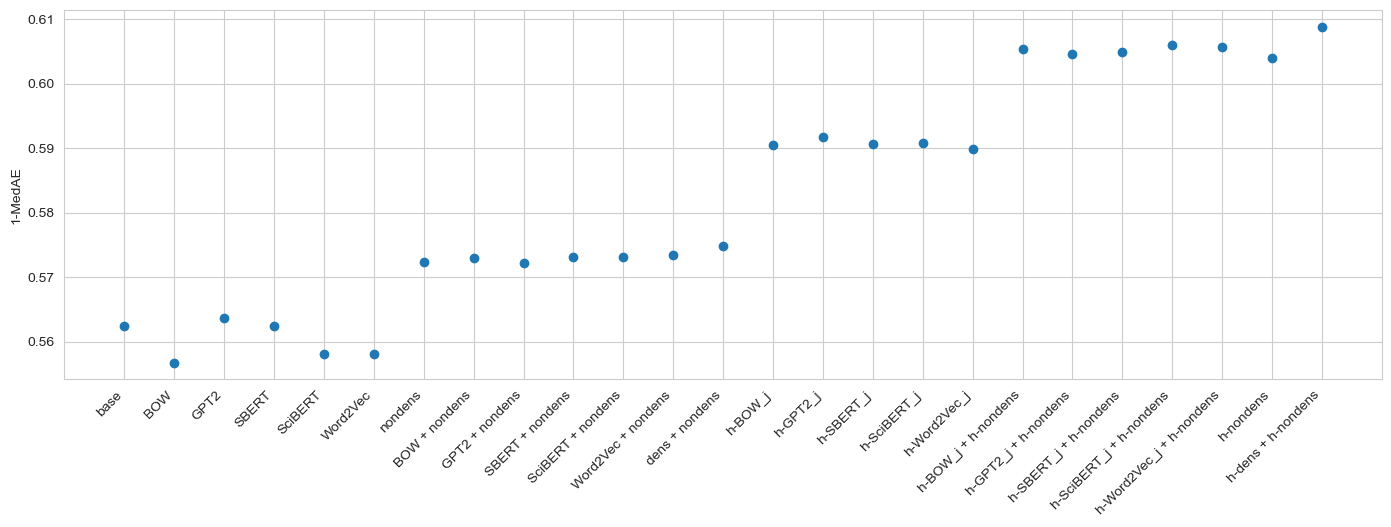

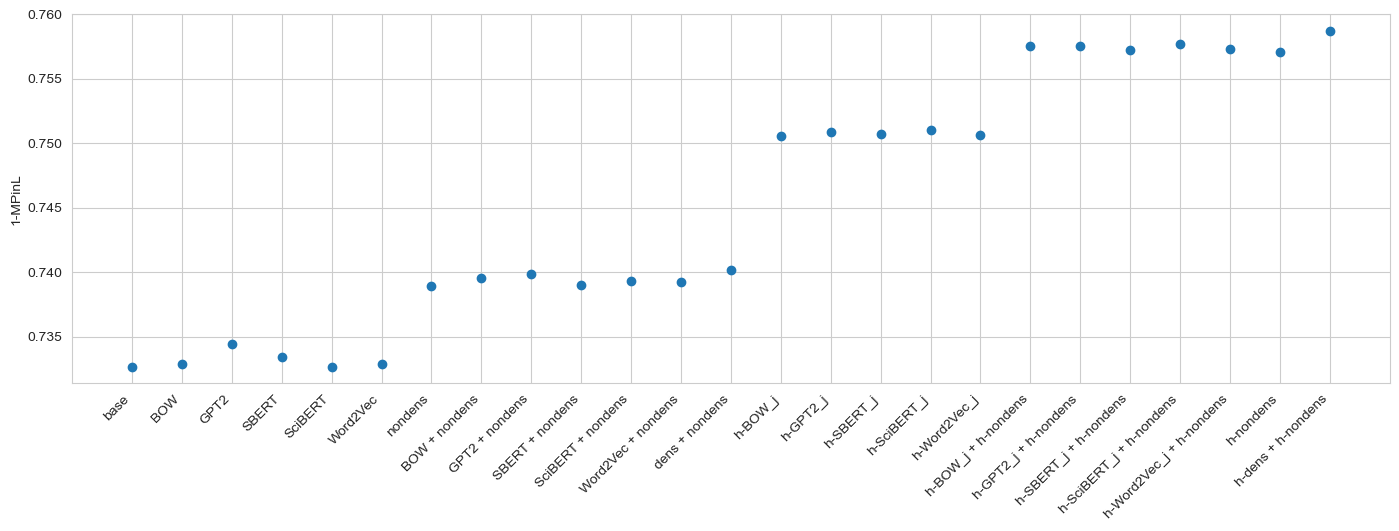

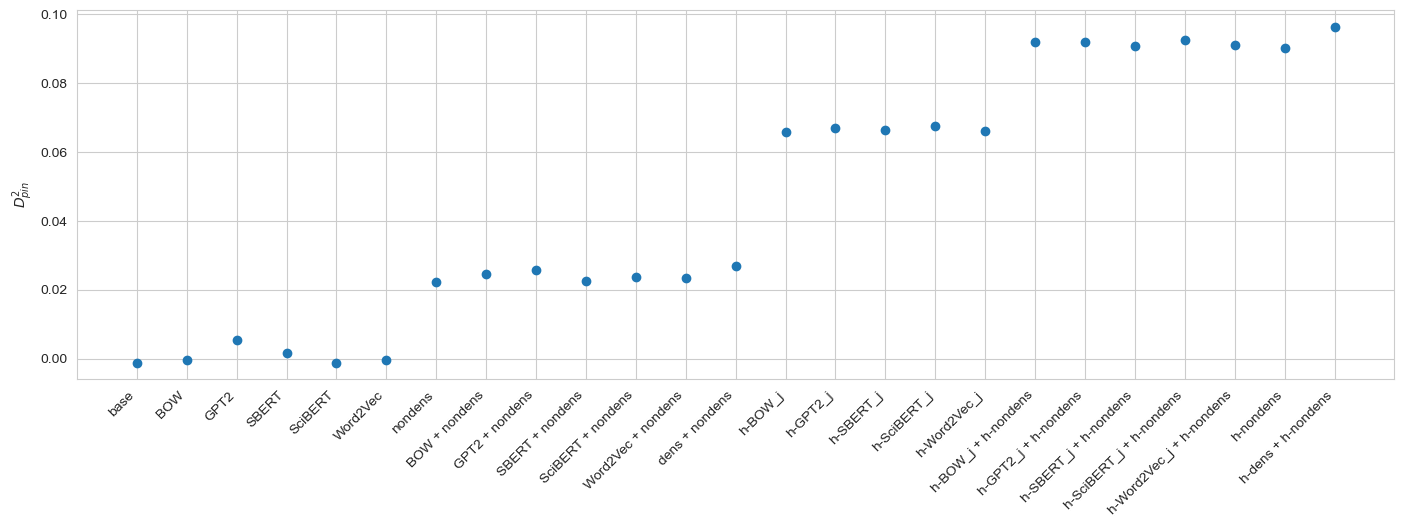

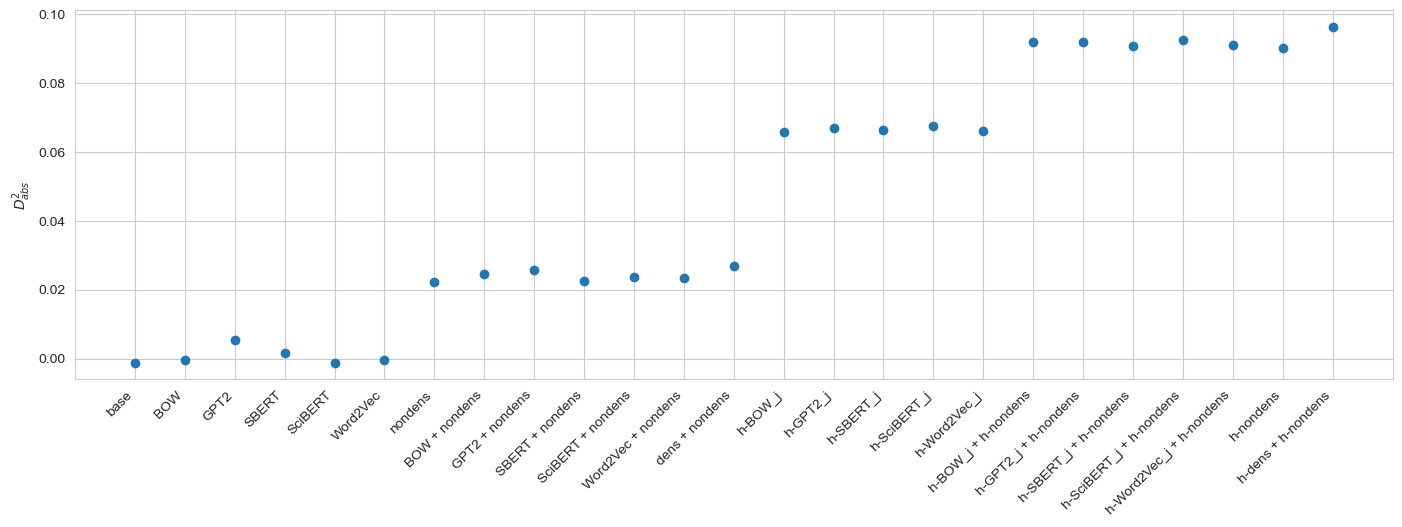

In [107]:
y_test = df_eval_copy.loc[df_test.index, "log_cpy"]

for metric_label, metric_fn in metrics.items():
    # Calculate the metric
    metric = []
    for i, model_i in enumerate(results.index):
        metric_i = metric_fn(y_test, y_pred_orig[model_i])
        metric.append(metric_i)

    # Plot
    fig = plt.figure(figsize=(6.8 * len(results) / 10, 4.8))
    ax = plt.gca()

    x = np.arange(len(results))
    ax.scatter(
        x,
        metric,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(results.index, rotation=45, ha="right")
    ax.set_ylabel(metric_label)